In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.cloud import storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import griddata
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm, trange
import seaborn as sns
import random
import pickle
from os import replace
import statsmodels.api as sm

In [ ]:
# Install required libraries
!pip install google-cloud-storage==2.11.0 --quiet

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 3.6 MB/s eta 0:00:00


#### **Data Preparation**

In [ ]:
# --- Load and Prepare Return Data
ret_file_path = '/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/daily_return_1996_202001.csv'
df_ret = pd.read_csv(ret_file_path) # PERMNO	date	TICKER	COMNAM	DLRET	RET	vwretd	ewretd

ret_daily = df_ret[['date', 'PERMNO', 'RET', 'DLRET']]
ret_daily['RET'] = pd.to_numeric(ret_daily['RET'], errors='coerce').fillna(0)
ret_daily['DLRET'] = pd.to_numeric(ret_daily['DLRET'], errors='coerce')
ret_daily['GROSS'] = 1 + ret_daily['RET']
ret_daily['DEL_GROSS'] = np.where(ret_daily['DLRET'].notna(), 1 + ret_daily['DLRET'], 1.0)
ret_daily['DAILY_TOTAL_GROSS'] = ret_daily['GROSS'] * ret_daily['DEL_GROSS']
ret_daily['month'] = pd.to_datetime(ret_daily['date']).dt.to_period('M')

ret_month = (
    ret_daily.groupby(['PERMNO', 'month'])['DAILY_TOTAL_GROSS']
    .apply(lambda x: x.prod() - 1)
    .reset_index()
    .rename(columns={'DAILY_TOTAL_GROSS': 'Rm'})
)

ret_month['Rm_next'] = ret_month.groupby('PERMNO')['Rm'].shift(-1)
ret = ret_month.dropna(subset=['Rm_next']).drop(columns='Rm')

ret = ret[ret['month'] >= '2005-01'] # filter 2005 onwards

/tmp/ipython-input-3161814702.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ret = pd.read_csv(ret_file_path) # PERMNO	date	TICKER	COMNAM	DLRET	RET	vwretd	ewretd
/tmp/ipython-input-3161814702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret_daily['RET'] = pd.to_numeric(ret_daily['RET'], errors='coerce').fillna(0)
/tmp/ipython-input-3161814702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret_daily['DLRET'] = pd.to_numeric(ret_dai

In [ ]:
# --- Load and Prepare IVS (Initial Version: Skip interpolation) ---
df_ivs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/ivs_1996_2019_clean.csv')
df_ivs['delta'] = df_ivs['delta'] / 100
df_ivs['date'] = pd.to_datetime(df_ivs['date'])
df_ivs = df_ivs[df_ivs['date'] >='2005-01-31']

In [ ]:
# --- Descriptive Analysis ---
total_grid = len(df_ivs['delta'].unique()) * len(df_ivs['days'].unique())

# Group by (date,permno) and calculate stats
grouped = df_ivs.groupby(['date', 'permno'])
summary = grouped['impl_volatility'].count().reset_index(name='count')
summary[(summary['count'] == 0)==True]
summary['type'] = np.where(summary['count'] == 0, 'Missing',
                   np.where(summary['count'] < total_grid, 'Incomplete', 'Complete'))

# Aggregate by year and image type
summary['year'] = summary['date'].dt.year
yearly_counts = summary.groupby(['year', 'type']).size().unstack(fill_value=0)

# Add total and percentage columns
yearly_counts['Total'] = yearly_counts.sum(axis=1)
for t in ['Missing', 'Incomplete', 'Complete']:
    if t in yearly_counts:
        yearly_counts[f'{t} (%)'] = (yearly_counts[t] / yearly_counts['Total'] * 100).round(2)
    else:
        yearly_counts[t] = 0
        yearly_counts[f'{t} (%)'] = 0.00

descriptive_table_output = yearly_counts.reset_index().sort_values('year')
# descriptive_table_output.to_excel('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/descriptive_table_output.xlsx', index=False)

plt.figure(figsize=(7,5))
plt.rcParams['font.family'] = 'serif'

bottom = np.zeros(len(yearly_counts))
colors = {'Missing': 'red', 'Incomplete': 'firebrick', 'Complete': 'gold'}

for image_type in ['Complete','Missing', 'Incomplete']:
    if image_type in yearly_counts:
        plt.bar(yearly_counts.index, yearly_counts[image_type], bottom=bottom, label=f'{image_type} Images', color=colors[image_type])
        bottom += yearly_counts[image_type]

plt.xlabel('Year', fontweight='bold')
plt.ylabel('# Observations' , fontweight='bold')
# plt.title('Yearly Observation Counts by Image Type')
plt.legend(fontsize=9)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/descriptive_table_0730.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# Drop remove all rows with 10-days-to-expiration due to high missing iv
df_ivs = df_ivs.drop(df_ivs[df_ivs['days'] == 10].index)

# --- Define interpolation function
def interpolate_surface(row, deltas, days):
    # Reshape to 2D surface [delta x days]
    surface = row.values.reshape(len(deltas), len(days))
    interpolated_surface = np.full_like(surface, np.nan)

    # Boolean masks
    call_mask = np.array(deltas) > 0
    put_mask = np.array(deltas) < 0

    def interpolate_half(half_mask):
        half_surface = surface[half_mask, :]
        if np.isnan(half_surface).all():
            return np.full_like(half_surface, np.nan)

        # 2D mask and points
        known_mask = ~np.isnan(half_surface) # Non-missing data points
        if known_mask.sum() < 5:  # Too sparse
            return half_surface

        sub_deltas = np.array(deltas)[half_mask]
        delta_subgrid, day_subgrid = np.meshgrid(sub_deltas, days, indexing='ij')
        sub_points = np.column_stack([delta_subgrid.ravel(), day_subgrid.ravel()])

        known_points = sub_points[known_mask.ravel()]
        known_values = half_surface[known_mask]

        interp_values = griddata(known_points, known_values, sub_points, method='linear')

        if np.isnan(interp_values).any():
            nearest_values = griddata(known_points, known_values, sub_points, method='nearest')
            interp_values[np.isnan(interp_values)] = nearest_values[np.isnan(interp_values)]

        return interp_values.reshape(half_surface.shape)

    # Interpolate call and put sides separately
    if np.any(call_mask):
        interpolated_surface[call_mask, :] = interpolate_half(call_mask)
    if np.any(put_mask):
         interpolated_surface[put_mask, :] = interpolate_half(put_mask)

    # Return as a Series with original MultiIndex
    return pd.Series(interpolated_surface.ravel(), index=row.index)

iv_pivot = df_ivs.pivot_table(index=['permno', 'date'], columns=['delta', 'days'], values='impl_volatility')

# Perform interpolation using **full** deltas and days
deltas = sorted(iv_pivot.columns.get_level_values(0).unique())
days = sorted(iv_pivot.columns.get_level_values(1).unique())
iv_interp = iv_pivot.apply(interpolate_surface, axis=1, args=(deltas, days))
# Check NaN after interpolation
iv_interp.isna().sum().sum()

# Sort OTM delta to guarantee IVS smoothness
otm_deltas = [d for d in deltas if (d >= -0.5 and d < 0) or (d > 0 and d <= 0.5)]
ordered_otm_deltas = sorted([d for d in list(otm_deltas) if d > 0]) + \
                     sorted([d for d in list(otm_deltas) if d < 0])
all_days = sorted(list(days))
ordered_otm_columns = [(d, t) for t in all_days for d in ordered_otm_deltas]
iv_prep = iv_interp.reindex(columns=ordered_otm_columns)

# Save prepared IVS to csv file
# iv_save = iv_prep.stack([0, 1]).reset_index()
# iv_save.columns = ['permno', 'date', 'delta', 'days', 'impl_volatility']
# iv_save.to_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/ivs_prep_1996_2019.csv')
# Convenient for reloading next time.
# Avoid interpolation again. Only need to pivot reloaded dataframe.
# df_ivs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/10yrs/ivs_prep_2010_2019.csv')

In [ ]:
# --- Load and Prepare IVS (Updated Version: Skip interpolation) ---
df_ivs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/ivs_prep_1996_2019.csv')
df_ivs = df_ivs[df_ivs['date'] >='2005-01-31']
iv_pivot = df_ivs.pivot_table(index=['date', 'permno'], columns=['delta', 'days'], values='impl_volatility')

# Sort OTM delta to guarantee IVS smoothness
deltas = sorted(iv_pivot.columns.get_level_values(0).unique())
days = sorted(iv_pivot.columns.get_level_values(1).unique())
otm_deltas = [d for d in deltas if (d >= -0.5 and d < 0) or (d > 0 and d <= 0.5)]
ordered_otm_deltas = sorted([d for d in list(otm_deltas) if d > 0]) + \
                     sorted([d for d in list(otm_deltas) if d < 0])
all_days = sorted(list(days))
ordered_otm_columns = [(d, t) for t in all_days for d in ordered_otm_deltas]
iv_prep = iv_pivot.reindex(columns=ordered_otm_columns)
iv_prep.info()
iv_prep

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 82336 entries, ('2005-01-31', np.int64(10104)) to ('2019-12-31', np.int64(93436))
Columns: 180 entries, (np.float64(0.1), np.int64(30)) to (np.float64(-0.1), np.int64(730))
dtypes: float64(180)
memory usage: 113.4+ MB


delta                  0.10      0.15      0.20      0.25      0.30      0.35  \
days                    30        30        30        30        30        30    
date       permno                                                               
2005-01-31 10104   0.329022  0.294448  0.267575  0.251739  0.240666  0.243392   
           10107   0.228061  0.179060  0.156384  0.147674  0.143748  0.141531   
           10138   0.248774  0.229984  0.217274  0.209239  0.202714  0.201243   
           10145   0.255337  0.217843  0.196093  0.189487  0.187369  0.186513   
           10460   0.209394  0.209856  0.210712  0.211627  0.212172  0.212394   
...                     ...       ...       ...       ...       ...       ...   
2019-12-31 93096   0.252317  0.224892  0.190608  0.169350  0.164932  0.166234   
           93132   0.389474  0.364226  0.338017  0.320611  0.315363  0.319967   
           93246   0.304142  0.296594  0.289971  0.289271  0.295366  0.303230   
           93429   0.231412  0.234743  0.227200  0.209545  0.194968  0.190688   
           93436   0.503513  0.500525  0.498087  0.496686  0.497235  0.499301   

delta                  0.40      0.45      0.50     -0.50  ...      0.50  \
days                    30        30        30        30   ...       730   
date       permno                                          ...             
2005-01-31 10104   0.254009  0.263975  0.270622  0.265418  ...  0.254840   
           10107   0.140384  0.140641  0.145812  0.147534  ...  0.176084   
           10138   0.201575  0.201933  0.202277  0.204288  ...  0.217862   
           10145   0.186231  0.189606  0.198712  0.204125  ...  0.213315   
           10460   0.212469  0.212493  0.212502  0.212481  ...  0.197668   
...                     ...       ...       ...       ...  ...       ...   
2019-12-31 93096   0.168307  0.170385  0.172590  0.172759  ...  0.243068   
           93132   0.331027  0.339715  0.341646  0.341241  ...  0.328278   
           93246   0.305816  0.302874  0.298824  0.299158  ...  0.340469   
           93429   0.192001  0.194625  0.197691  0.196635  ...  0.234015   
           93436   0.501643  0.503772  0.505817  0.507240  ...  0.433778   

delta                 -0.50     -0.45     -0.40     -0.35     -0.30     -0.25  \
days                    730       730       730       730       730       730   
date       permno                                                               
2005-01-31 10104   0.256151  0.257982  0.266732  0.277961  0.282554  0.288921   
           10107   0.180098  0.181916  0.184794  0.189214  0.193197  0.198221   
           10138   0.217269  0.218377  0.223821  0.237869  0.247682  0.254538   
           10145   0.211505  0.217532  0.220929  0.223754  0.230613  0.239718   
           10460   0.198914  0.199539  0.205587  0.209715  0.210037  0.210295   
...                     ...       ...       ...       ...       ...       ...   
2019-12-31 93096   0.234423  0.238798  0.243310  0.248190  0.254363  0.262630   
           93132   0.318021  0.321082  0.325250  0.329582  0.333933  0.340014   
           93246   0.326512  0.329703  0.333822  0.337663  0.341901  0.348998   
           93429   0.226288  0.230809  0.235775  0.241073  0.246718  0.252937   
           93436   0.434432  0.441389  0.448039  0.455283  0.465679  0.482182   

delta                 -0.20     -0.15     -0.10  
days                    730       730       730  
date       permno                                
2005-01-31 10104   0.303302  0.320833  0.337157  
           10107   0.205547  0.214132  0.223763  
           10138   0.266796  0.282785  0.296619  
           10145   0.246610  0.253534  0.260174  
           10460   0.211677  0.217126  0.225123  
...                     ...       ...       ...  
2019-12-31 93096   0.272826  0.284002  0.294745  
           93132   0.351748  0.371444  0.395834  
           93246   0.362939  0.383344  0.402175  
           93429   0.260163  0.269122  0.279544  
           9343

/tmp/ipython-input-225-2740271999.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


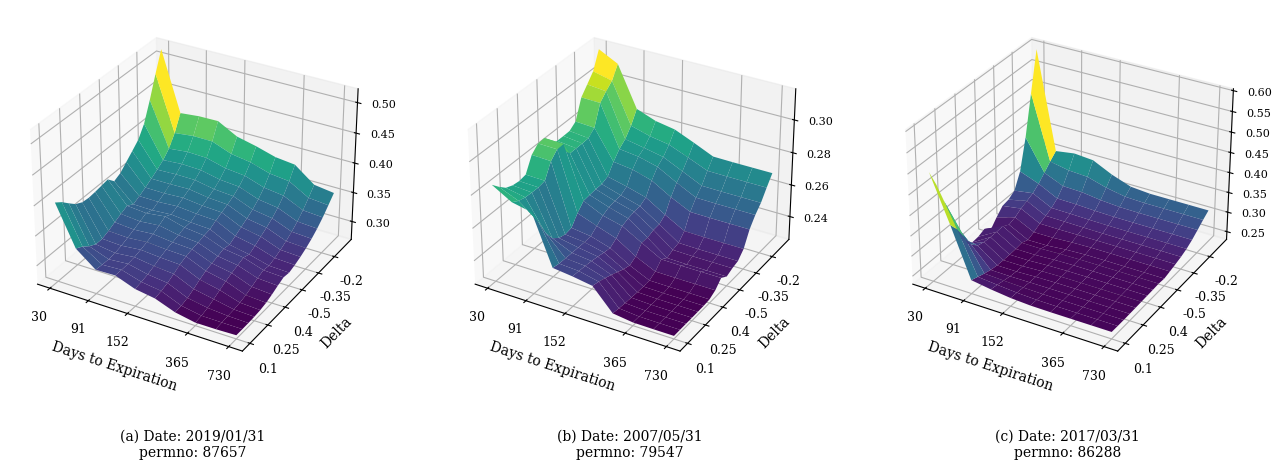

In [ ]:
# Plot implied volatility surface
# Randomly select 3 rows (i.e., 3 (date, permno) IV surfaces)
sampled_idx = iv_prep.sample(n=3).index

# Extract delta and days values from column MultiIndex
deltas = iv_prep.columns.get_level_values(0).unique()
deltas_tick = list(range(len(deltas)))
days = iv_prep.columns.get_level_values(1).unique()
days_tick = list(range(len(days)))
X, Y = np.meshgrid(deltas_tick, days_tick)

fig = plt.figure(figsize=(16, 8))
plt.rcParams['font.family'] = 'serif'

for i, (date, permno) in enumerate(sampled_idx):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')

    Z = iv_prep.loc[(date, permno)].values.reshape(len(days), len(deltas))

    ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='none')

    ax.set_xlabel("Days to Expiration", fontsize=10)
    ax.set_ylabel("Delta", fontsize=10)
    # ax.view_init(elev=30, azim=120)

    selected_days = [30, 91, 152, 365, 730]
    x_ticks = [i for i, d in enumerate(days) if d in selected_days]
    x_labels = [str(days[i]) for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=9)

    y_ticks = list(range(0, len(deltas), 3))
    y_labels = [str(round(deltas[i], 2)) for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=9)

    ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    for label in ax.zaxis.get_ticklabels():
        label.set_fontsize(8)

    date = pd.to_datetime(date)
    caption = f"({chr(97+i)}) Date: {date.strftime('%Y/%m/%d')}\npermno: {permno}"
    ax.text2D(0.5, -0.15, caption, transform=ax.transAxes,
              ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/ivs_surface_0730.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# --- Merge with monthly return target
X_all = []
X_all.append(iv_prep.values)

X_flat = np.vstack(X_all)
X_df = pd.DataFrame(X_flat, index=iv_prep.index)

meta_df = pd.DataFrame(index=iv_prep.index).reset_index()
meta_df['month'] = pd.to_datetime(meta_df['date']).dt.to_period('M')
meta_df.rename(columns={'permno': 'PERMNO'}, inplace=True)

df_all = meta_df.merge(ret, on=['month', 'PERMNO'])
df_all['merge_index'] = list(zip(df_all['date'], df_all['PERMNO']))
X_matched_df = X_df.loc[df_all['merge_index']].copy()
X_matched_df.index = pd.MultiIndex.from_frame(df_all[['month', 'PERMNO']])

X_matched = X_matched_df.values
y = df_all['Rm_next'].values

final_deltas = sorted(list(set([col[0] for col in ordered_otm_columns])))
final_maturities = sorted(list(set([col[1] for col in ordered_otm_columns])))

n_samples, n_features = X_matched.shape
n_deltas = len(final_deltas)
n_maturities = len(final_maturities)

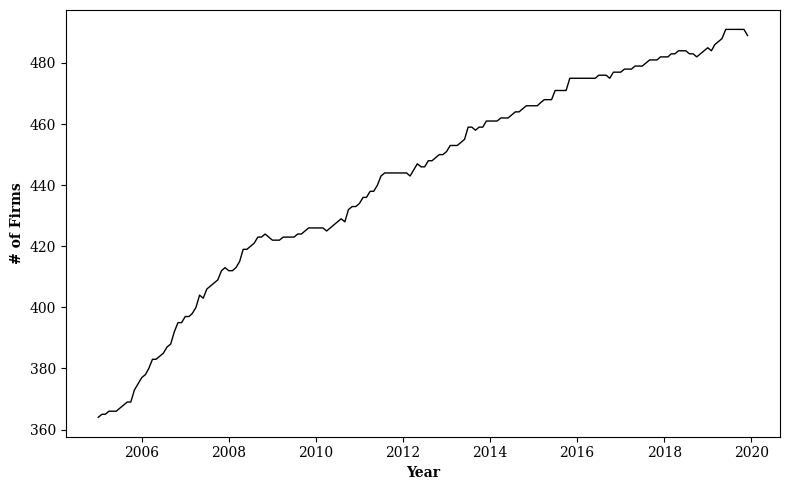

In [ ]:
# Plot evolution of number of stocks
ticker_count_by_date = df_all.groupby('month').size()
ticker_count_by_date.index = ticker_count_by_date.index.to_timestamp()

plt.figure(figsize=(8, 5))
plt.rcParams['font.family'] = 'serif'
plt.plot(ticker_count_by_date.index, ticker_count_by_date.values, linestyle='-', color='k', linewidth=1)
plt.xlabel("Year", fontweight='bold')
plt.ylabel("# of Firms", fontweight='bold')
plt.grid(False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/num_firms.png', dpi=150)
plt.show()

In [ ]:
def set_global_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

#### **Spanning Regression Prep**

In [ ]:
# Define model-based and option feature-based portfolio returns
# For each month, rank stocks accordingly and long top 10%, short bottom 10%
def model_returns(df):
    df['rank'] = df.groupby('month')['y_pred'].rank(method='first')
    df['n'] = df.groupby('month')['y_pred'].transform('count')
    long = df[df['rank'] >= 0.9 * df['n']]
    short = df[df['rank'] <= 0.1 * df['n']]
    long_ret = long.groupby('month')['y_true'].mean()
    short_ret = short.groupby('month')['y_true'].mean()
    return long_ret - short_ret

def option_factor_returns(df, feature_col):
    df_copy = df.copy()
    df_copy['y_pred'] = df_copy[feature_col]
    return model_returns(df_copy)

In [ ]:
# Consider transation cost
def model_returns_with_cost(df, f_base=0.001):
    df = df.copy()

    # 1.Assign long-short weights
    df['rank'] = df.groupby('month')['y_pred'].rank(method='first')
    df['n'] = df.groupby('month')['y_pred'].transform('count')
    df['w_t'] = 0
    long_mask = df['rank'] >= 0.9 * df['n']
    short_mask = df['rank'] <= 0.1 * df['n']
    df.loc[long_mask, 'w_t'] = 1 / df[long_mask].groupby('month')['PERMNO'].transform('count')
    df.loc[short_mask, 'w_t'] = -1 / df[short_mask].groupby('month')['PERMNO'].transform('count')
    df['r_i'] = df['y_true']

    # 2.Calculate portfolio pre-fees gross return for each month
    portfolio = df[long_mask | short_mask]
    r_port  = portfolio.groupby('month').apply(lambda x: (x['w_t'] * x['r_i']).sum())
    r_port .name = 'r_port'
    df = df.merge(r_port , on='month', how='left')

    # 3.Shift weights and returns to align for
    # Note: y_true is shifted ahead from the next month previously to meet training need
    # To account for transaction cost, we need return for current month, hence, we shift it back
    df['w_t_prev'] = df.groupby('PERMNO')['w_t'].shift(1)
    df['r_i_curr'] = df.groupby('PERMNO')['r_i'].shift(1)
    df['r_port_curr'] = df.groupby('PERMNO')['r_port'].shift(1)

    # 4.Calculate adjusted previous weights (only if previous data exists)
    df['adj_prev_weight'] = ((1 + df['r_i_curr']) / (1 + df['r_port_curr'])) * df['w_t_prev']
    df['adj_prev_weight'] = df['adj_prev_weight'].fillna(0)

    # 5.Calculate transaction cost per stock: rebalancing cost + short-sell cost using previous month weight
    df['turnover'] = (df['w_t'] - df['adj_prev_weight']).abs()
    df['rebal_cost'] = f_base * df['turnover']
    df['short_cost'] = df['w_t_prev'].clip(upper=0).abs() * f_base
    df['short_cost'] = df['short_cost'].fillna(0)
    df['total_cost'] = df['rebal_cost'] + df['short_cost']

    # 6.Identify stocks inclued in consecutive months
    included_prev = df['w_t_prev'].fillna(0) != 0
    included_curr = df['w_t'] != 0
    included_union = included_prev | included_curr

    # 7.Total transaction cost per month (only for included_union)
    cost_df = df[included_union]
    f_bar = cost_df.groupby('month')['total_cost'].sum()
    f_bar.name = 'f_bar'

    # 8. Final net-of-cost return
    final_df = pd.concat([r_port, f_bar], axis=1).dropna()
    net_returns = (1 + final_df['r_port']) * (1 - final_df['f_bar']) - 1
    net_returns.name = 'net_return'

    return net_returns

def option_factor_returns_with_cost(df, feature_col, f_base=0.001):
    df_copy = df.copy()
    df_copy['y_pred'] = df_copy[feature_col]
    return model_returns_with_cost(df_copy, f_base=f_base)

In [ ]:
# Load Fama-French Three Factors
df_ff3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/FF3_Research_Data_Factors_2016-2019.csv', index_col=0)
df_ff3.index = pd.to_datetime(df_ff3.index.astype(str), format='%Y%m').to_period('M')

In [ ]:
# Compute Option Characteristics

# --- CIV and PIV ---
civ = iv_prep[(0.50, 30)]
piv = iv_prep[(-0.50, 30)]

# --- Skew: average put IV minus average call IV ---
iv_30d = iv_prep.loc[:, iv_prep.columns.get_level_values("days") == 30]
deltas = iv_30d.columns.get_level_values("delta")

call_deltas = deltas[(deltas >= 0.2) & (deltas <= 0.4)]
put_deltas = deltas[(deltas <= -0.2) & (deltas >= -0.4)]

call_cols = [(delta, 30) for delta in call_deltas]
put_cols = [(delta, 30) for delta in put_deltas]

avg_call_iv = iv_30d[call_cols].mean(axis=1)
avg_put_iv = iv_30d[put_cols].mean(axis=1)

skew = avg_put_iv - avg_call_iv

# --- IV Spread ---
atm_call = (0.50, 30)
atm_put  = (-0.50, 30)
otm_put  = (-0.20, 30)

# IVS_atm: 0.50 delta call and -0.50 delta put
ivs_atm = iv_30d[atm_put] - iv_30d[atm_call]

# IVS_otm: 0.50 delta call and -0.20 delta put
ivs_otm = iv_30d[otm_put] - iv_30d[atm_call]

option_chars = pd.DataFrame({
    'CIV': civ,
    'PIV': piv,
    'Skew': skew,
    'IVS_atm': ivs_atm,
    'IVS_otm': ivs_otm
})

# Construct dataframe for option_chars with respect to forecasting window
val_end_month = '2015-12'

option_chars_reset = option_chars.reset_index()  # columns: date, ticker, CIV, PIV, SKEW, IVS_atm, IVS_otm
option_chars_reset.rename(columns={'permno': 'PERMNO'}, inplace=True)

# Merge with df_all on date and permno
merged_df = pd.merge(df_all, option_chars_reset, on=['date', 'PERMNO'], how='left')
df_opt = merged_df[merged_df['month'] > val_end_month].copy()
df_opt = df_opt[['month', 'PERMNO', 'Rm_next', 'CIV', 'PIV', 'Skew', 'IVS_atm', 'IVS_otm']]
df_opt.rename(columns={'Rm_next': 'y_true'}, inplace=True)

In [ ]:
# Option-based portfolio return without transaction cost
CIV_returns = option_factor_returns(df_opt, 'CIV')
CIV_returns = CIV_returns.to_frame()
CIV_returns.rename(columns={'y_true': 'CIV'}, inplace=True)

PIV_returns = option_factor_returns(df_opt, 'PIV')
PIV_returns = PIV_returns.to_frame()
PIV_returns.rename(columns={'y_true': 'PIV'}, inplace=True)

Skew_returns = option_factor_returns(df_opt, 'Skew')
Skew_returns = Skew_returns.to_frame()
Skew_returns.rename(columns={'y_true': 'Skew'}, inplace=True)

IVS_ATM_returns = option_factor_returns(df_opt, 'IVS_atm')
IVS_ATM_returns = IVS_ATM_returns.to_frame()
IVS_ATM_returns.rename(columns={'y_true': 'IVS_atm'}, inplace=True)

IVS_OTM_returns = option_factor_returns(df_opt, 'IVS_otm')
IVS_OTM_returns = IVS_OTM_returns.to_frame()
IVS_OTM_returns.rename(columns={'y_true': 'IVS_otm'}, inplace=True)

In [ ]:
# Option-based portfolio return with transaction cost
CIV_returns = option_factor_returns_with_cost(df_opt, 'CIV')
CIV_returns = CIV_returns.to_frame()
CIV_returns.rename(columns={'net_return': 'CIV'}, inplace=True)

PIV_returns = option_factor_returns_with_cost(df_opt, 'PIV')
PIV_returns = PIV_returns.to_frame()
PIV_returns.rename(columns={'net_return': 'PIV'}, inplace=True)

Skew_returns = option_factor_returns_with_cost(df_opt, 'Skew')
Skew_returns = Skew_returns.to_frame()
Skew_returns.rename(columns={'net_return': 'Skew'}, inplace=True)

IVS_ATM_returns = option_factor_returns_with_cost(df_opt, 'IVS_atm')
IVS_ATM_returns = IVS_ATM_returns.to_frame()
IVS_ATM_returns.rename(columns={'net_return': 'IVS_atm'}, inplace=True)

IVS_OTM_returns = option_factor_returns_with_cost(df_opt, 'IVS_otm')
IVS_OTM_returns = IVS_OTM_returns.to_frame()
IVS_OTM_returns.rename(columns={'net_return': 'IVS_otm'}, inplace=True)

/tmp/ipython-input-2859625167.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02083333 0.02083333 0.02083333 ... 0.02040816 0.02040816 0.02040816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[long_mask, 'w_t'] = 1 / df[long_mask].groupby('month')['PERMNO'].transform('count')
/tmp/ipython-input-2859625167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_port  = portfolio.groupby('month').apply(lambda x: (x['w_t'] * x['r_i']).sum())
/tmp/ipython-input-2859625167.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an

#### **FNN**

In [ ]:
# --- Model Input for FNN

X = X_matched.astype(np.float32)
y = y.astype(np.float32)

# Split dataset accordingly
train_end_month = '2013-12'
val_end_month = '2015-12'

train_idx = df_all[df_all['month'] <= train_end_month].index
val_idx = df_all[(df_all['month'] > train_end_month) & (df_all['month'] <= val_end_month)].index
test_idx = df_all[df_all['month'] > val_end_month].index

X_train = X[train_idx]
y_train = y[train_idx]

X_val = X[val_idx]
y_val = y[val_idx]

X_test = X[test_idx]
y_test = y[test_idx]

# --- Define 3-layer FNN model
def fnn():
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_flat.shape[1],)),
        # layers.Dense(128, activation='relu'),
        # layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
    return model

# --- Ensemble
n_models = 10
all_preds_fnn = []

train_losses = []
val_losses = []
min_val_losses = []

for seed in trange(n_models):
    set_global_seed(seed)
    model = fnn()

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    min_val_losses.append(min(history.history['val_loss']))
    y_pred = model.predict(X_test).flatten()
    all_preds_fnn.append(y_pred)

# Average predictions
ensemble_pred = np.mean(all_preds_fnn, axis=0)

# Evaluate
print("Ensemble R²:", r2_score(y_test, ensemble_pred))

# Save results
save_all_fnn = "/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10fnn_1e-4_20epo_64batch_10pati.pkl"
with open(save_all_fnn, "wb") as f:
    pickle.dump(all_preds_fnn, f)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0270 - val_loss: 0.0058
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

 10%|█         | 1/10 [01:18<11:43, 78.15s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0100 - val_loss: 0.0059
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0061
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

 20%|██        | 2/10 [03:21<13:57, 104.64s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0108 - val_loss: 0.0063
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0061
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0061
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0095 - val_loss: 0.0060
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.

 30%|███       | 3/10 [04:49<11:18, 96.91s/it] 

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0161 - val_loss: 0.0057
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0057
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 40%|████      | 4/10 [05:18<07:00, 70.12s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0225 - val_loss: 0.0060
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.

 50%|█████     | 5/10 [06:17<05:32, 66.41s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0141 - val_loss: 0.0057
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0101 - val_loss: 0.0056
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0100 - val_loss: 0.0057
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

 60%|██████    | 6/10 [07:38<04:45, 71.34s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0190 - val_loss: 0.0061
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0102 - val_loss: 0.0057
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

 70%|███████   | 7/10 [08:37<03:21, 67.21s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0127 - val_loss: 0.0057
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.0057
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.0058
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0058
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0058
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

 80%|████████  | 8/10 [10:38<02:48, 84.41s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0103 - val_loss: 0.0056
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0055
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0055
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

 90%|█████████ | 9/10 [11:15<01:09, 69.40s/it]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0166 - val_loss: 0.0057
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0057
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094 - val_loss: 0.0057
Epoch 4/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0094 - val_loss: 0.0057
Epoch 5/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094 - val_loss: 0.0057
Epoch 6/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 7/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 8/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 9/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 10/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 11/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 12/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.

100%|██████████| 10/10 [12:54<00:00, 77.45s/it]

Ensemble R²: 0.0042536258697509766


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10fnn_1e-4_20epo_64batch_10pati.pkl', 'rb') as f:
    all_preds_fnn = pickle.load(f)

y_preds_10 = np.mean(all_preds_fnn, axis=0)
r2 = r2_score(y_test, y_preds_10)

# MSE, RMSE, MAE
mse = mean_squared_error(y_test, y_preds_10)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_preds_10)

print(f"R²: {r2:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
# print(f"Avg Min Val loss: {np.mean(min_val_losses):.6f}")

R²: 0.004254
MSE: 0.005457
RMSE: 0.073869
MAE: 0.053986


In [ ]:
# Compute monthly return and Sharpe ratio for H-L portfolio
ensemble_pred = np.mean(all_preds_fnn, axis=0)

df_m = pd.DataFrame({'y_pred': ensemble_pred, 'y_true': y_test})
df_m['PERMNO'] = df_all.iloc[-len(y_test):,:]['PERMNO'].reset_index(drop=True)
df_m['month'] = df_all.iloc[-len(y_test):,:]['month'].reset_index(drop=True)
df_m = df_m[['PERMNO','month','y_pred','y_true']]

FNN_returns = model_returns(df_m)
FNN_returns = FNN_returns.to_frame()
FNN_returns.rename(columns={'y_true': 'FNN_10'}, inplace=True)

FNN_sharpe = FNN_returns.mean() / FNN_returns.std() * np.sqrt(12)
print(f"FNN Sharpe Ratio: {FNN_sharpe[0]:.6f}")

FNN Sharpe Ratio: 1.761688


/tmp/ipython-input-77-139680635.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"FNN Sharpe Ratio: {FNN_sharpe[0]:.6f}")


In [ ]:
X = pd.concat([df_ff3, CIV_returns, Skew_returns, IVS_ATM_returns, IVS_OTM_returns], axis=1)
X.drop('rf', axis=1, inplace=True)
X = sm.add_constant(X)

y = FNN_returns['FNN_10'] - df_ff3['rf']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     43.86
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           8.51e-17
Time:                        16:25:36   Log-Likelihood:                 148.93
No. Observations:                  48   AIC:                            -281.9
Df Residuals:                      40   BIC:                            -266.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.133      0.0

#### **CNN1**

In [ ]:
# --- Model Input for CNN
# Flatten the 10x18 matrix to vector
X = X_matched.reshape(n_samples, n_maturities, n_deltas, 1).astype(np.float32)
y = y.astype(np.float32)

# Split dataset accordingly
train_end_month = '2013-12'
val_end_month = '2015-12'

train_idx = df_all[df_all['month'] <= train_end_month].index
val_idx = df_all[(df_all['month'] > train_end_month) & (df_all['month'] <= val_end_month)].index
test_idx = df_all[df_all['month'] > val_end_month].index

X_train = X[train_idx]
y_train = y[train_idx]

X_val = X[val_idx]
y_val = y[val_idx]

X_test = X[test_idx]
y_test = y[test_idx]
y_test_cnn = y_test

In [ ]:
# --- Define CNN1 Architecture
def cnn1():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(n_maturities, n_deltas, 1)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # Maybe replace FC with GAP when repoting
        # layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
    return model

# --- Ensemble
n_models = 50
all_preds_cnn1 = []

train_losses_cnn1 = []
val_losses_cnn1 = []
min_val_losses_cnn1 = []

for seed in trange(n_models):
    set_global_seed(seed)
    model = cnn1()

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stop])

    train_losses_cnn1.append(history.history['loss'])
    val_losses_cnn1.append(history.history['val_loss'])
    min_val_losses_cnn1.append(min(history.history['val_loss']))
    y_pred = model.predict(X_test).flatten()
    all_preds_cnn1.append(y_pred)

# Average predictions
ensemble_pred = np.mean(all_preds_cnn1, axis=0)

# Evaluate
print("Ensemble R²:", r2_score(y_test, ensemble_pred))

# Save results
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cnn1_50ens_losses.pkl', 'wb') as f:
    pickle.dump({
        'train': train_losses_cnn1,
        'val': val_losses_cnn1,
        'min_val': min_val_losses_cnn1
    }, f)

save_all_cnn1 = "/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_50cnn1_1e-4_50epo_64batch_10pati.pkl"
with open(save_all_cnn1, "wb") as f:
    pickle.dump(all_preds_cnn1, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10cnn1_1e-4_50epo_64batch_10pati.pkl', 'rb') as f:
    all_preds_cnn1 = pickle.load(f)

y_preds_10 = np.mean(all_preds_cnn1, axis=0)
r2 = r2_score(y_test_cnn, y_preds_10)

# MSE, RMSE, MAE
mse = mean_squared_error(y_test_cnn, y_preds_10)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_cnn, y_preds_10)

print(f"R²: {r2:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

R²: -0.006348
MSE: 0.005515
RMSE: 0.074261
MAE: 0.054356


In [ ]:
# Compute monthly return and Sharpe ratio for H-L portfolio
ensemble_pred = np.mean(all_preds_cnn1, axis=0)

df_m = pd.DataFrame({'y_pred': ensemble_pred, 'y_true': y_test_cnn})
df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
df_m = df_m[['PERMNO','month','y_pred','y_true']]

# Transaction cost not considered
CNN1_returns = model_returns(df_m)
CNN1_returns = CNN1_returns.to_frame()
CNN1_returns.rename(columns={'y_true': 'CNN1_10'}, inplace=True)

CNN1_sharpe = CNN1_returns.mean() / CNN1_returns.std() * np.sqrt(12)
print(f"CNN1 Sharpe Ratio (f_base = 0bp): {CNN1_sharpe[0]:.6f}")

# Transaction cost considered
CNN1_returns = model_returns_with_cost(df_m)
CNN1_returns = CNN1_returns.to_frame()
CNN1_returns.rename(columns={'net_return': 'CNN1_10'}, inplace=True)

CNN1_sharpe = CNN1_returns.mean() / CNN1_returns.std() * np.sqrt(12)
print(f"CNN1 Sharpe Ratio (f_base = 10bp): {CNN1_sharpe[0]:.6f}")

CNN1 Sharpe Ratio (f_base = 0bp): 1.293763
CNN1 Sharpe Ratio (f_base = 10bp): 0.685830


/tmp/ipython-input-76-4006600138.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"CNN1 Sharpe Ratio (f_base = 0bp): {CNN1_sharpe[0]:.6f}")
/tmp/ipython-input-10-2859625167.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02083333 0.02083333 0.02083333 ... 0.02040816 0.02040816 0.02040816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[long_mask, 'w_t'] = 1 / df[long_mask].groupby('month')['PERMNO'].transform('count')
/tmp/ipython-input-10-2859625167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. E

In [ ]:
X = pd.concat([df_ff3, CIV_returns, Skew_returns, IVS_ATM_returns, IVS_OTM_returns], axis=1)
X.drop('rf', axis=1, inplace=True)
X = sm.add_constant(X)

y = CNN1_returns['CNN1_10'] - df_ff3['rf']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     3.815
Date:                Tue, 29 Jul 2025   Prob (F-statistic):            0.00291
Time:                        13:18:11   Log-Likelihood:                 128.44
No. Observations:                  48   AIC:                            -240.9
Df Residuals:                      40   BIC:                            -225.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.003     -0.755      0.4

#### **CNN3**

In [ ]:
# --- Define CNN3 Architecture
def cnn3(input_shape=(10, 18, 1)):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Block 2
    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Block 3
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Block 4
    # model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    # # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())

    # Final layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

# --- Model Ensembling
n_models = 50
all_preds_cnn3 = []

train_losses_cnn3 = []
val_losses_cnn3 = []
min_val_losses_cnn3 = []

for seed in trange(n_models):
    set_global_seed(seed)
    model = cnn3()

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=70, batch_size=128, verbose=1, validation_data=(X_val,y_val), callbacks=[early_stop])

    train_losses_cnn3.append(history.history['loss'])
    val_losses_cnn3.append(history.history['val_loss'])
    min_val_losses_cnn3.append(min(history.history['val_loss']))
    y_pred = model.predict(X_test).flatten()
    all_preds_cnn3.append(y_pred)

# Average predictions
ensemble_pred = np.mean(all_preds_cnn3, axis=0)

# Evaluate
print("Ensemble R²:", r2_score(y_test, ensemble_pred))

# Save results
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cnn3_50ens_losses.pkl', 'wb') as f:
    pickle.dump({
        'train': train_losses_cnn3,
        'val': val_losses_cnn3,
        'min_val': min_val_losses_cnn3
    }, f)

with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_50cnn3_70epo_128batch_20pati.pkl', 'wb') as f:
    pickle.dump(all_preds_cnn3, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10cnn3_70epo_128batch_20pati.pkl', 'rb') as f:
    all_preds_cnn3 = pickle.load(f)

y_preds_10 = np.mean(all_preds_cnn3, axis=0)
r2 = r2_score(y_test_cnn, y_preds_10)

# MSE, RMSE, MAE
mse = mean_squared_error(y_test_cnn, y_preds_10)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_cnn, y_preds_10)

print(f"R²: {r2:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

R²: -0.012472
MSE: 0.005548
RMSE: 0.074487
MAE: 0.054628


In [ ]:
# Compute monthly return and Sharpe ratio for H-L portfolio
ensemble_pred = np.mean(all_preds_cnn3, axis=0)

df_m = pd.DataFrame({'y_pred': ensemble_pred, 'y_true': y_test_cnn})
df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
df_m = df_m[['PERMNO','month','y_pred','y_true']]

# Transaction cost not considered
CNN3_returns = model_returns(df_m)
CNN3_returns = CNN3_returns.to_frame()
CNN3_returns.rename(columns={'y_true': 'CNN3_10'}, inplace=True)

CNN3_sharpe = CNN3_returns.mean() / CNN3_returns.std() * np.sqrt(12)
print(f"CNN3 Sharpe Ratio (f_base = 0bp): {CNN3_sharpe[0]:.6f}")

# Transaction cost not considered
CNN3_returns = model_returns_with_cost(df_m)
CNN3_returns = CNN3_returns.to_frame()
CNN3_returns.rename(columns={'net_return': 'CNN3_10'}, inplace=True)

CNN3_sharpe = CNN3_returns.mean() / CNN3_returns.std() * np.sqrt(12)
print(f"CNN3 Sharpe Ratio (f_base = 10bp): {CNN3_sharpe[0]:.6f}")

CNN3 Sharpe Ratio (f_base = 0bp): 1.085427
CNN3 Sharpe Ratio (f_base = 10bp): 0.591540


/tmp/ipython-input-79-3563537551.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"CNN3 Sharpe Ratio (f_base = 0bp): {CNN3_sharpe[0]:.6f}")
/tmp/ipython-input-10-2859625167.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02083333 0.02083333 0.02083333 ... 0.02040816 0.02040816 0.02040816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[long_mask, 'w_t'] = 1 / df[long_mask].groupby('month')['PERMNO'].transform('count')
/tmp/ipython-input-10-2859625167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. E

In [ ]:
X = pd.concat([df_ff3, CIV_returns, Skew_returns, IVS_ATM_returns, IVS_OTM_returns], axis=1)
X.drop('rf', axis=1, inplace=True)
X = sm.add_constant(X)

y = CNN3_returns['CNN3_10'] - df_ff3['rf']

model = sm.OLS(y, X).fit()
print(model.summary())

# with open("/content/drive/MyDrive/Colab Notebooks/Dissertation Project/Final/ols_summary.txt", "w") as f:
#     f.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     6.633
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           3.16e-05
Time:                        13:22:03   Log-Likelihood:                 125.80
No. Observations:                  48   AIC:                            -235.6
Df Residuals:                      40   BIC:                            -220.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.003     -1.257      0.2

#### **LSTM**

In [ ]:
# Prepare inputs
final_deltas = sorted(list(set([col[0] for col in ordered_otm_columns])))
final_maturities = sorted(list(set([col[1] for col in ordered_otm_columns])))

n_deltas = len(final_deltas)
n_maturities = len(final_maturities)

meta_df = pd.DataFrame(index=iv_prep.index).reset_index()
meta_df['month'] = pd.to_datetime(meta_df['date']).dt.to_period('M')
meta_df.rename(columns={'permno': 'PERMNO'}, inplace=True)
df_all = meta_df.merge(ret, on=['month', 'PERMNO'])

# Rolling 6-month IVS sequence for LSTM
X_seq, y_seq, meta_seq = [], [], []
flattened_feature_size = n_maturities * n_deltas

for permno, group in df_all.groupby('PERMNO'):
    group = group.sort_values('month')
    for i in range(6, len(group)):
        month_target = group.iloc[i]['month']
        dates_lag = group.iloc[i-6:i]['date'].values
        try:
            ivs_flat = [iv_prep.loc[(d, permno)].values.flatten() for d in dates_lag]
            X_seq.append(np.stack(ivs_flat))  # shape: (6, 180)
            y_seq.append(group.iloc[i]['Rm_next'])
            meta_seq.append((month_target, permno))
        except:
            continue

# check for X_seq
# iv_prep.loc[('2010-06-30', 'A')]
# Check for y_seq
# df_all[df_all['TICKER']=='A'].head(20)

X_seq = np.array(X_seq).astype(np.float32)
y_seq = np.array(y_seq).astype(np.float32)

train_end_month = '2013-12'
val_end_month = '2015-12'

meta_df = pd.DataFrame(meta_seq, columns=['month', 'PERMNO'])
train_mask = meta_df['month'] <= pd.Period(train_end_month)
val_mask = (meta_df['month'] > pd.Period(train_end_month)) & (meta_df['month'] <= pd.Period(val_end_month))
test_mask = meta_df['month'] > pd.Period(val_end_month)

X_train = X_seq[train_mask]
y_train = y_seq[train_mask]

X_val = X_seq[val_mask]
y_val = y_seq[val_mask]

X_test = X_seq[test_mask]
y_test = y_seq[test_mask]
y_test_lstm = y_test

In [ ]:
def lstm(n_timesteps=6, flattened_feature_size=180, lstm_units=32):
    input_shape = (n_timesteps, flattened_feature_size)

    model_input = layers.Input(shape=input_shape)
    x = layers.LSTM(lstm_units)(model_input)
    output = layers.Dense(1)(x)

    model = models.Model(inputs=model_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

# Example usage (for demonstration, not part of the main loop)
# lstm_model_example = lstm()
# lstm_model_example.summary()

In [ ]:
n_models = 50
all_preds_lstm = []

train_losses_lstm = []
val_losses_lstm = []
min_val_losses_lstm = []

# n_timesteps = X_train.shape[1]
# flattened_feature_size = X_train.shape[2]
# lstm_units_for_ensemble = 32

for seed in trange(n_models):
    set_global_seed(seed)

    model = lstm()
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        verbose=1,
        callbacks=[early_stop]
    )

    train_losses_lstm.append(history.history['loss'])
    val_losses_lstm.append(history.history['val_loss'])
    min_val_losses_lstm.append(min(history.history['val_loss']))

    y_pred = model.predict(X_test).flatten()
    all_preds_lstm.append(y_pred)

# Average predictions from ensemble
ensemble_pred_lstm = np.mean(all_preds_lstm, axis=0)

# R² Score for LSTM-only ensemble
r2_lstm = r2_score(y_test, ensemble_pred_lstm)
print(f"LSTM Ensemble R²: {r2_lstm:.4f}")

# Save results for LSTM ensemble
with open('/content/drive/My Drive/Colab Notebooks/Dissertation Project/20yrs/lstm_50ens_losses.pkl', 'wb') as f:
    pickle.dump({
        'train': train_losses_lstm,
        'val': val_losses_lstm,
        'min_val': min_val_losses_lstm
    }, f)

with open('/content/drive/My Drive/Colab Notebooks/Dissertation Project/20yrs/all_50lstm_50epo_128batch_15pati.pkl', 'wb') as f:
    pickle.dump(all_preds_lstm, f)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0126 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

  2%|▏         | 1/50 [01:07<55:01, 67.37s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0120 - val_loss: 0.0053
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

  4%|▍         | 2/50 [02:12<52:45, 65.94s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0114 - val_loss: 0.0066
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0060
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

  6%|▌         | 3/50 [02:58<44:36, 56.95s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0123 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

  8%|▊         | 4/50 [03:44<40:23, 52.68s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0119 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 10%|█         | 5/50 [04:25<36:19, 48.43s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0161 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 12%|█▏        | 6/50 [05:12<35:01, 47.77s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0137 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

 14%|█▍        | 7/50 [06:05<35:31, 49.57s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0145 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 16%|█▌        | 8/50 [08:03<49:52, 71.24s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0122 - val_loss: 0.0053
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0052
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0057
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

 18%|█▊        | 9/50 [08:45<42:37, 62.38s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0145 - val_loss: 0.0053
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0089 - val_loss: 0.0057
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 20%|██        | 10/50 [09:30<37:57, 56.93s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0128 - val_loss: 0.0063
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0063
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0061
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 22%|██▏       | 11/50 [10:40<39:34, 60.89s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0128 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 24%|██▍       | 12/50 [11:25<35:31, 56.10s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0131 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0098 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 26%|██▌       | 13/50 [12:17<33:42, 54.67s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0148 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 28%|██▊       | 14/50 [13:04<31:32, 52.58s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0126 - val_loss: 0.0053
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 30%|███       | 15/50 [13:49<29:20, 50.30s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0134 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 32%|███▏      | 16/50 [14:37<27:59, 49.40s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0138 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 34%|███▍      | 17/50 [15:42<29:47, 54.18s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0130 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0098 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0097 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 36%|███▌      | 18/50 [16:40<29:30, 55.32s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0135 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 38%|███▊      | 19/50 [17:23<26:37, 51.54s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0165 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 40%|████      | 20/50 [18:03<24:06, 48.21s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0231 - val_loss: 0.0050
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 42%|████▏     | 21/50 [18:44<22:13, 45.98s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0117 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0086 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 44%|████▍     | 22/50 [19:33<21:58, 47.08s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0134 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0102 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0101 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0101 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0101 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0100 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0100 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0099 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 46%|████▌     | 23/50 [20:16<20:31, 45.61s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0113 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 48%|████▊     | 24/50 [21:03<19:59, 46.12s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0128 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0063
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0060
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 50%|█████     | 25/50 [21:43<18:29, 44.37s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0121 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 52%|█████▏    | 26/50 [22:39<19:05, 47.73s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0175 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 54%|█████▍    | 27/50 [23:46<20:32, 53.61s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0145 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 56%|█████▌    | 28/50 [24:41<19:50, 54.12s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0140 - val_loss: 0.0056
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 58%|█████▊    | 29/50 [25:33<18:41, 53.40s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0160 - val_loss: 0.0053
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 60%|██████    | 30/50 [26:30<18:09, 54.47s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0126 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 62%|██████▏   | 31/50 [27:15<16:21, 51.65s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0135 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

 64%|██████▍   | 32/50 [28:03<15:10, 50.56s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0190 - val_loss: 0.0050
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 66%|██████▌   | 33/50 [28:54<14:21, 50.66s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0133 - val_loss: 0.0050
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 68%|██████▊   | 34/50 [29:34<12:39, 47.49s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0287 - val_loss: 0.0050
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 70%|███████   | 35/50 [30:16<11:27, 45.86s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0134 - val_loss: 0.0059
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0059
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 72%|███████▏  | 36/50 [31:17<11:44, 50.30s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0153 - val_loss: 0.0061
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096 - val_loss: 0.0058
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 74%|███████▍  | 37/50 [32:12<11:14, 51.85s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0157 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 76%|███████▌  | 38/50 [32:55<09:48, 49.04s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0193 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

 78%|███████▊  | 39/50 [34:02<09:57, 54.30s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0204 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0096 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

 80%|████████  | 40/50 [35:16<10:03, 60.34s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0118 - val_loss: 0.0060
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0064
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0095 - val_loss: 0.0065
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0095 - val_loss: 0.0059
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 82%|████████▏ | 41/50 [36:12<08:51, 59.02s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0131 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 84%|████████▍ | 42/50 [37:26<08:27, 63.47s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0116 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

 86%|████████▌ | 43/50 [38:10<06:43, 57.59s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0163 - val_loss: 0.0050
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 88%|████████▊ | 44/50 [38:52<05:17, 52.99s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0126 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0090 - val_loss: 0.0063
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 90%|█████████ | 45/50 [39:53<04:37, 55.44s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0132 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0097 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0097 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

 92%|█████████▏| 46/50 [40:39<03:30, 52.72s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0154 - val_loss: 0.0051
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089 - val_loss: 0.0053
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 94%|█████████▍| 47/50 [41:26<02:32, 50.97s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0186 - val_loss: 0.0052
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 96%|█████████▌| 48/50 [42:29<01:48, 54.37s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0179 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 98%|█████████▊| 49/50 [43:12<00:51, 51.20s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0132 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0052
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0088 - val_loss: 0.0053
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0087 - val_loss: 0.0053
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

100%|██████████| 50/50 [44:00<00:00, 52.81s/it]

LSTM Ensemble R²: -0.0103


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_preds_lstm_10epo_128batch_15pati.pkl', 'rb') as f:
    all_preds_lstm = pickle.load(f)

y_preds_10 = np.mean(all_preds_lstm, axis=0)
r2 = r2_score(y_test_lstm, y_preds_10)

# MSE, RMSE, MAE
mse_lstm = mean_squared_error(y_test_lstm, y_preds_10)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_lstm, y_preds_10)

print(f"LSTM R²: {r2_lstm:.6f}")
print(f"LSTM MSE: {mse_lstm:.6f}")
print(f"LSTM RMSE: {rmse_lstm:.6f}")
print(f"LSTM MAE: {mae_lstm:.6f}")

LSTM R²: -0.007822
LSTM MSE: 0.005505
LSTM RMSE: 0.074196
LSTM MAE: 0.054384


In [ ]:
# Compute monthly return and Sharpe ratio for H-L portfolio
ensemble_pred = np.mean(all_preds_lstm, axis=0)

df_m = pd.DataFrame({'y_pred': ensemble_pred, 'y_true': y_test_lstm})
df_m['PERMNO'] = df_all.iloc[-len(y_test_lstm):,:]['PERMNO'].reset_index(drop=True)
df_m['month'] = df_all.iloc[-len(y_test_lstm):,:]['month'].reset_index(drop=True)
df_m = df_m[['PERMNO','month','y_pred','y_true']]

# Transaction cost not considered
LSTM_returns = model_returns(df_m)
LSTM_returns = LSTM_returns.to_frame()
LSTM_returns.rename(columns={'y_true': 'LSTM_10'}, inplace=True)

LSTM_sharpe = LSTM_returns.mean() / LSTM_returns.std() * np.sqrt(12)
print(f"LSTM Sharpe Ratio (fees = 0bp): {LSTM_sharpe[0]:.6f}")

# Transaction cost considered
LSTM_returns = model_returns_with_cost(df_m)
LSTM_returns = LSTM_returns.to_frame()
LSTM_returns.rename(columns={'net_return': 'LSTM_10'}, inplace=True)

LSTM_sharpe = LSTM_returns.mean() / LSTM_returns.std() * np.sqrt(12)
print(f"LSTM Sharpe Ratio (fees = 10bp): {LSTM_sharpe[0]:.6f}")

LSTM Sharpe Ratio (fees = 0bp): 1.091893
LSTM Sharpe Ratio (fees = 10bp): 0.352406


/tmp/ipython-input-82-2218753124.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"LSTM Sharpe Ratio (fees = 0bp): {LSTM_sharpe[0]:.6f}")
/tmp/ipython-input-10-2859625167.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02857143 0.02857143 0.02857143 ... 0.02040816 0.02040816 0.02040816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[long_mask, 'w_t'] = 1 / df[long_mask].groupby('month')['PERMNO'].transform('count')
/tmp/ipython-input-10-2859625167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Eit

In [ ]:
X = pd.concat([df_ff3, CIV_returns, Skew_returns, IVS_ATM_returns, IVS_OTM_returns], axis=1)
X.drop('rf', axis=1, inplace=True)
X = sm.add_constant(X)

y = LSTM_returns['LSTM_10'] - df_ff3['rf']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     1.807
Date:                Tue, 29 Jul 2025   Prob (F-statistic):              0.113
Time:                        13:23:44   Log-Likelihood:                 123.84
No. Observations:                  48   AIC:                            -231.7
Df Residuals:                      40   BIC:                            -216.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.236      0.8

#### **CNNLSTM**

In [ ]:
# Prepare inputs
final_deltas = sorted(list(set([col[0] for col in ordered_otm_columns])))
final_maturities = sorted(list(set([col[1] for col in ordered_otm_columns])))

n_deltas = len(final_deltas)
n_maturities = len(final_maturities)

meta_df = pd.DataFrame(index=iv_prep.index).reset_index()
meta_df['month'] = pd.to_datetime(meta_df['date']).dt.to_period('M')
meta_df.rename(columns={'permno': 'PERMNO'}, inplace=True)
df_all = meta_df.merge(ret, on=['month', 'PERMNO'])

# Rolling 6-month IVS sequence
X_seq, y_seq, meta_seq = [], [], []
for permno, group in df_all.groupby('PERMNO'):
    group = group.sort_values('month')
    for i in range(6, len(group)):
        month_target = group.iloc[i]['month']
        dates_lag = group.iloc[i-6:i]['date'].values
        try:
            ivs = [iv_prep.loc[(d, permno)].values.reshape(n_maturities, n_deltas) for d in dates_lag]
            X_seq.append(np.stack(ivs))  # shape: (6, 10, 18)
            y_seq.append(group.iloc[i]['Rm_next'])
            meta_seq.append((month_target, permno))
        except:
            continue

# check for X_seq
# iv_prep.loc[('2010-06-30', 'A')]
# Check for y_seq
# df_all[df_all['TICKER']=='A'].head(20)

X_seq = np.array(X_seq).astype(np.float32)
y_seq = np.array(y_seq).astype(np.float32)

train_end_month = '2013-12'
val_end_month = '2015-12'

meta_df = pd.DataFrame(meta_seq, columns=['month', 'PERMNO'])
train_mask = meta_df['month'] <= pd.Period(train_end_month)
val_mask = (meta_df['month'] > pd.Period(train_end_month)) & (meta_df['month'] <= pd.Period(val_end_month))
test_mask = meta_df['month'] > pd.Period(val_end_month)

X_train = X_seq[train_mask]
y_train = y_seq[train_mask]

X_val = X_seq[val_mask]
y_val = y_seq[val_mask]

X_test = X_seq[test_mask]
y_test = y_seq[test_mask]
y_test_cnnlstm = y_test

In [ ]:
# --- Define CNN+LSTM Architecture
def cnn_lstm(n_timesteps=6, n_maturities=10, n_deltas=18, lstm_units=32):
    input_shape = (n_timesteps, n_maturities, n_deltas, 1)
    model_input = layers.Input(shape=input_shape)

    # TimeDistributed CNN Block
    x = layers.TimeDistributed(layers.Conv2D(8, (3, 3), padding='same', activation='relu'))(model_input)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.Dropout(0.2)(x)

    # LSTM
    x = layers.LSTM(lstm_units)(x)

    # Output
    output = layers.Dense(1)(x)

    model = models.Model(inputs=model_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

In [ ]:
# --- Ensemble training loop
n_models = 50
all_preds_cnnlstm = []

train_losses_cnnlstm = []
val_losses_cnnlstm = []
min_val_losses_cnnlstm = []

for seed in trange(n_models):
    # tf.keras.utils.set_random_seed(seed)
    set_global_seed(seed)
    model = cnn_lstm()

    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    history = model.fit(
        X_train[..., np.newaxis], y_train,
        validation_data=(X_test[..., np.newaxis], y_test),
        epochs=50, batch_size=128, verbose=1,
        callbacks=[early_stop]
    )

    train_losses_cnnlstm.append(history.history['loss'])
    val_losses_cnnlstm.append(history.history['val_loss'])
    min_val_losses_cnnlstm.append(min(history.history['val_loss']))

    y_pred = model.predict(X_test[..., np.newaxis]).flatten()
    all_preds_cnnlstm.append(y_pred)

# Average predictions from ensemble
ensemble_pred = np.mean(all_preds_cnnlstm, axis=0)

# R² Score
print("CNN+LSTM Ensemble R²:", r2_score(y_test, ensemble_pred))

# Save results
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cnnlstm_50ens_losses.pkl', 'wb') as f:
    pickle.dump({
        'train': train_losses_cnnlstm,
        'val': val_losses_cnnlstm,
        'min_val': min_val_losses_cnnlstm
    }, f)

with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_50cnnlstm_50epo_128batch_15pati.pkl', 'wb') as f:
    pickle.dump(all_preds_cnnlstm, f)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0105 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

  2%|▏         | 1/50 [01:17<1:03:19, 77.54s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

  4%|▍         | 2/50 [02:27<58:18, 72.89s/it]  

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0111 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

  6%|▌         | 3/50 [03:43<58:24, 74.56s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

  8%|▊         | 4/50 [05:09<1:00:35, 79.03s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 10%|█         | 5/50 [06:40<1:02:29, 83.32s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0117 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 12%|█▏        | 6/50 [07:50<57:38, 78.61s/it]  

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 14%|█▍        | 7/50 [09:05<55:36, 77.59s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 16%|█▌        | 8/50 [10:18<53:14, 76.07s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0102 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 18%|█▊        | 9/50 [11:27<50:24, 73.78s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086 - val_loss: 0.0057
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 20%|██        | 10/50 [12:42<49:37, 74.44s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 22%|██▏       | 11/50 [13:52<47:20, 72.84s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 24%|██▍       | 12/50 [15:00<45:19, 71.55s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 26%|██▌       | 13/50 [16:12<44:07, 71.54s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0096 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 28%|██▊       | 14/50 [17:21<42:28, 70.80s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 30%|███       | 15/50 [18:31<41:10, 70.58s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0057
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 32%|███▏      | 16/50 [19:52<41:43, 73.65s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0057
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 34%|███▍      | 17/50 [21:04<40:20, 73.36s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 36%|███▌      | 18/50 [22:17<39:02, 73.20s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 38%|███▊      | 19/50 [23:31<37:50, 73.23s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 40%|████      | 20/50 [24:40<35:58, 71.95s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0057
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 42%|████▏     | 21/50 [25:57<35:32, 73.52s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 44%|████▍     | 22/50 [27:06<33:39, 72.13s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0101 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0098 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 46%|████▌     | 23/50 [28:16<32:15, 71.69s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0096 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 48%|████▊     | 24/50 [29:25<30:38, 70.70s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 50%|█████     | 25/50 [30:33<29:09, 69.96s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0095 - val_loss: 0.0057
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0057
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0058
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0057
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0058
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 52%|█████▏    | 26/50 [33:51<43:19, 108.30s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 54%|█████▍    | 27/50 [34:59<36:53, 96.24s/it] 

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0100 - val_loss: 0.0057
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0057
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0057
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 56%|█████▌    | 28/50 [36:42<36:04, 98.39s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0058
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 58%|█████▊    | 29/50 [37:50<31:12, 89.18s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0096 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 60%|██████    | 30/50 [38:58<27:35, 82.76s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0058
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086 - val_loss: 0.0058
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 62%|██████▏   | 31/50 [41:14<31:20, 98.97s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 64%|██████▍   | 32/50 [42:28<27:24, 91.34s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 66%|██████▌   | 33/50 [43:37<24:01, 84.78s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 68%|██████▊   | 34/50 [44:49<21:35, 80.94s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 70%|███████   | 35/50 [45:59<19:23, 77.57s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 72%|███████▏  | 36/50 [47:09<17:32, 75.19s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0101 - val_loss: 0.0056
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 74%|███████▍  | 37/50 [48:22<16:08, 74.52s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 76%|███████▌  | 38/50 [49:32<14:39, 73.31s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 78%|███████▊  | 39/50 [50:42<13:14, 72.20s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 80%|████████  | 40/50 [51:50<11:51, 71.14s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 82%|████████▏ | 41/50 [53:03<10:43, 71.47s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 84%|████████▍ | 42/50 [54:24<09:56, 74.51s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 86%|████████▌ | 43/50 [55:33<08:29, 72.84s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 88%|████████▊ | 44/50 [56:42<07:09, 71.61s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 90%|█████████ | 45/50 [57:50<05:52, 70.59s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0097 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0095 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 92%|█████████▏| 46/50 [59:00<04:40, 70.25s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0085 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 94%|█████████▍| 47/50 [1:00:10<03:30, 70.20s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 96%|█████████▌| 48/50 [1:01:19<02:20, 70.03s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0057
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0089 - val_loss: 0.0058
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

 98%|█████████▊| 49/50 [1:02:33<01:11, 71.04s/it]

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0107 - val_loss: 0.0054
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 12/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 50/50 [1:03:43<00:00, 76.48s/it]

CNN+LSTM Ensemble R²: 0.002011239528656006


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10cnnlstm_50epo_128batch_15pati.pkl', 'rb') as f:
    all_preds_cnnlstm = pickle.load(f)

y_preds_10 = np.mean(all_preds_cnnlstm, axis=0)
r2 = r2_score(y_test_cnnlstm, y_preds_10)

# MSE, RMSE, MAE
mse = mean_squared_error(y_test_cnnlstm, y_preds_10)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_cnnlstm, y_preds_10)

print(f"R²: {r2:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

R²: -0.001591
MSE: 0.005457
RMSE: 0.073874
MAE: 0.054102


In [ ]:
# Compute monthly return and Sharpe ratio for H-L portfolio
ensemble_pred = np.mean(all_preds_cnnlstm, axis=0)

df_m = pd.DataFrame({'y_pred': ensemble_pred, 'y_true': y_test_cnnlstm})
df_m['PERMNO'] = df_all.iloc[-len(y_test_cnnlstm):,:]['PERMNO'].reset_index(drop=True)
df_m['month'] = df_all.iloc[-len(y_test_cnnlstm):,:]['month'].reset_index(drop=True)
df_m = df_m[['PERMNO','month','y_pred','y_true']]

# Transaction cost not considered
CNNLSTM_returns = model_returns(df_m)
CNNLSTM_returns = CNNLSTM_returns.to_frame()
CNNLSTM_returns.rename(columns={'y_true': 'CNNLSTM_10'}, inplace=True)

CNNLSTM_sharpe = CNNLSTM_returns.mean() / CNNLSTM_returns.std() * np.sqrt(12)
print(f"CNNLSTM Sharpe Ratio (f_base = 0bp): {CNNLSTM_sharpe[0]:.6f}")

# Transaction cost considered
CNNLSTM_returns = model_returns_with_cost(df_m)
CNNLSTM_returns = CNNLSTM_returns.to_frame()
CNNLSTM_returns.rename(columns={'net_return': 'CNNLSTM_10'}, inplace=True)

CNNLSTM_sharpe = CNNLSTM_returns.mean() / CNNLSTM_returns.std() * np.sqrt(12)
print(f"CNNLSTM Sharpe Ratio (f_base = 10bp): {CNNLSTM_sharpe[0]:.6f}")

CNNLSTM Sharpe Ratio (f_base = 0bp): 3.179568
CNNLSTM Sharpe Ratio (f_base = 10bp): 1.600550


/tmp/ipython-input-243115040.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"CNNLSTM Sharpe Ratio (f_base = 0bp): {CNNLSTM_sharpe[0]:.6f}")
/tmp/ipython-input-3871520200.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02857143 0.02857143 0.02857143 ... 0.02040816 0.02040816 0.02040816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[long_mask, 'w_t'] = 1 / df[long_mask].groupby('month')['PERMNO'].transform('count')
/tmp/ipython-input-3871520200.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Eithe

In [ ]:
X = pd.concat([df_ff3, CIV_returns, Skew_returns, IVS_ATM_returns, IVS_OTM_returns], axis=1)
X.drop('rf', axis=1, inplace=True)
X = sm.add_constant(X)

y = CNNLSTM_returns['CNNLSTM_10'] - df_ff3['rf']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     3.148
Date:                Fri, 01 Aug 2025   Prob (F-statistic):            0.00957
Time:                        22:21:37   Log-Likelihood:                 130.14
No. Observations:                  48   AIC:                            -244.3
Df Residuals:                      40   BIC:                            -229.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.598      0.1

In [ ]:
all = pd.concat([df_ff3, CIV_returns, PIV_returns, Skew_returns, IVS_ATM_returns, IVS_OTM_returns, CNN1_returns, CNN3_returns, LSTM_returns, CNNLSTM_returns], axis=1)
all.to_excel('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/regression_0729_with_cost0.001.xlsx', index=False)

#### **Model Comparison**

In [ ]:
# Load Predictions
# 50 Ensembles results
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_50cnn1_1e-4_50epo_64batch_10pati.pkl', "rb") as f:
    all_preds_cnn1 = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_50cnn3_70epo_128batch_20pati.pkl', "rb") as f:
    all_preds_cnn3 = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_50lstm_50epo_128batch_15pati.pkl', 'rb') as f:
    all_preds_lstm = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_50cnnlstm_50epo_128batch_15pati.pkl', 'rb') as f:
    all_preds_cnnlstm = pickle.load(f)

# 10 Ensemble results
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10cnn1_1e-4_50epo_64batch_10pati.pkl', "rb") as f:
    all_preds_cnn1 = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10cnn3_70epo_128batch_20pati.pkl', "rb") as f:
    all_preds_cnn3 = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_preds_lstm_10epo_128batch_15pati.pkl', 'rb') as f:
    all_preds_lstm = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/all_10cnnlstm_50epo_128batch_15pati.pkl', 'rb') as f:
    all_preds_cnnlstm = pickle.load(f)

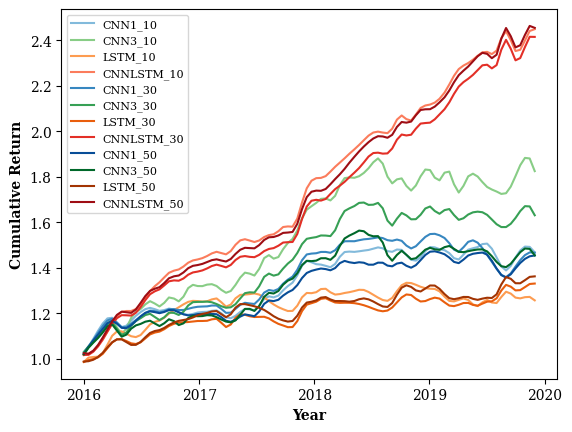

In [ ]:
# Cumulative returns
cumulative_returns_CNN1 = []
cumulative_returns_CNN3 = []
cumulative_returns_LSTM = []
cumulative_returns_CNNLSTM = []

for k in [10, 30, 50]:
    ensemble_pred_cnn1 = np.mean(all_preds_cnn1[:k], axis=0)
    ensemble_pred_cnn3 = np.mean(all_preds_cnn3[:k], axis=0)
    ensemble_pred_lstm = np.mean(all_preds_lstm[:k], axis=0)
    ensemble_pred_cnnlstm = np.mean(all_preds_cnnlstm[:k], axis=0)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn1, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN1_returns = model_returns(df_m)
    CNN1_returns = CNN1_returns.to_frame()
    CNN1_returns.rename(columns={'y_true': 'CNN1'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn3, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN3_returns = model_returns(df_m)
    CNN3_returns = CNN3_returns.to_frame()
    CNN3_returns.rename(columns={'y_true': 'CNN3'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_lstm, 'y_true': y_test_lstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_lstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_lstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    LSTM_returns = model_returns(df_m)
    LSTM_returns = LSTM_returns.to_frame()
    LSTM_returns.rename(columns={'y_true': 'LSTM'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnnlstm, 'y_true': y_test_cnnlstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnnlstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnnlstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNNLSTM_returns = model_returns(df_m)
    CNNLSTM_returns = CNNLSTM_returns.to_frame()
    CNNLSTM_returns.rename(columns={'y_true': 'CNNLSTM'}, inplace=True)

    cumulative_returns_CNN1.append((1 + CNN1_returns).cumprod())
    cumulative_returns_CNN3.append((1 + CNN3_returns).cumprod())
    cumulative_returns_LSTM.append((1 + LSTM_returns).cumprod())
    cumulative_returns_CNNLSTM.append((1 + CNNLSTM_returns).cumprod())

plt.figure(figsize=(7, 5))
plt.rcParams['font.family'] = 'serif'

cmap1 = cm.get_cmap('Blues', 10)
cmap2 = cm.get_cmap('Greens', 10)
cmap3 = cm.get_cmap('Oranges', 10)
cmap4 = cm.get_cmap('Reds', 10)

def smooth_plot(x_datetime, y_raw, label=None, color=None):
    x_num = x_datetime.map(pd.Timestamp.toordinal)
    x_dense = np.linspace(x_num.min(), x_num.max(), 96)

    spline = make_interp_spline(x_num, y_raw, k=3)
    y_smooth = spline(x_dense)

    # Convert x_dense back to datetime
    x_dense_datetime = [pd.Timestamp.fromordinal(int(val)) for val in x_dense]

    plt.plot(x_dense_datetime, y_smooth, label=label, color=color, linestyle='-', linewidth=1.5)

cumulative_returns_index = cumulative_returns_CNN1[0].index.to_timestamp()
smooth_plot(cumulative_returns_index, cumulative_returns_CNN1[0], label='CNN1_10', color = cmap1(4))
smooth_plot(cumulative_returns_index, cumulative_returns_CNN3[0], label='CNN3_10', color = cmap2(4))
smooth_plot(cumulative_returns_index, cumulative_returns_LSTM[0].values.flatten(), label='LSTM_10', color = cmap3(4))
smooth_plot(cumulative_returns_index, cumulative_returns_CNNLSTM[0].values.flatten(), label='CNNLSTM_10', color = cmap4(4))

smooth_plot(cumulative_returns_index, cumulative_returns_CNN1[1].values.flatten(), label='CNN1_30', color = cmap1(6))
smooth_plot(cumulative_returns_index, cumulative_returns_CNN3[1].values.flatten(), label='CNN3_30', color = cmap2(6))
smooth_plot(cumulative_returns_index, cumulative_returns_LSTM[1].values.flatten(), label='LSTM_30', color = cmap3(6))
smooth_plot(cumulative_returns_index, cumulative_returns_CNNLSTM[1].values.flatten(), label='CNNLSTM_30', color = cmap4(6))

smooth_plot(cumulative_returns_index, cumulative_returns_CNN1[2].values.flatten(), label='CNN1_50', color = cmap1(8))
smooth_plot(cumulative_returns_index, cumulative_returns_CNN3[2].values.flatten(), label='CNN3_50', color = cmap2(8))
smooth_plot(cumulative_returns_index, cumulative_returns_LSTM[2].values.flatten(), label='LSTM_50', color = cmap3(8))
smooth_plot(cumulative_returns_index, cumulative_returns_CNNLSTM[2].values.flatten(), label='CNNLSTM_50', color = cmap4(8))

# plt.title("Cumulative Return of Long-Short Portfolio (10 Ensembles)", fontsize=11)
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Cumulative Return", fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(False)
plt.legend(fontsize=8)
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cumulative_returns_0716.png', dpi=200, bbox_inches='tight')
plt.show()

/tmp/ipython-input-138-3182259159.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('Blues', 10)
/tmp/ipython-input-138-3182259159.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('Greens', 10)
/tmp/ipython-input-138-3182259159.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = cm.get_cmap('Oranges', 10)
/tmp/ipython-input-138-3182259159.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated

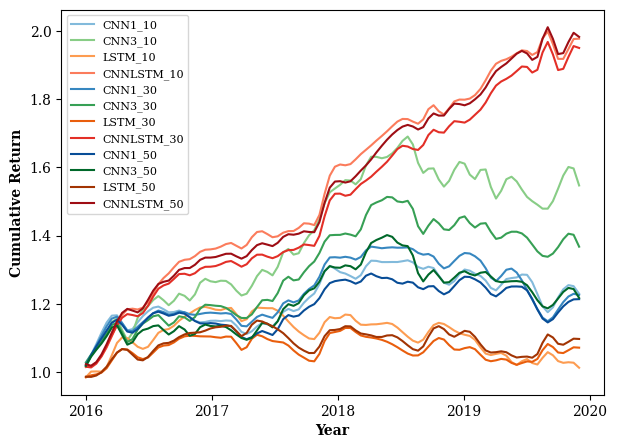

In [ ]:
# Cumulative returns with transaction cost
cumulative_returns_CNN1 = []
cumulative_returns_CNN3 = []
cumulative_returns_LSTM = []
cumulative_returns_CNNLSTM = []

for k in [10, 30, 50]:
    ensemble_pred_cnn1 = np.mean(all_preds_cnn1[:k], axis=0)
    ensemble_pred_cnn3 = np.mean(all_preds_cnn3[:k], axis=0)
    ensemble_pred_lstm = np.mean(all_preds_lstm[:k], axis=0)
    ensemble_pred_cnnlstm = np.mean(all_preds_cnnlstm[:k], axis=0)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn1, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN1_returns = model_returns_with_cost(df_m)
    CNN1_returns = CNN1_returns.to_frame()
    CNN1_returns.rename(columns={'y_true': 'CNN1'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn3, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN3_returns = model_returns_with_cost(df_m)
    CNN3_returns = CNN3_returns.to_frame()
    CNN3_returns.rename(columns={'y_true': 'CNN3'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_lstm, 'y_true': y_test_lstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_lstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_lstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    LSTM_returns = model_returns_with_cost(df_m)
    LSTM_returns = LSTM_returns.to_frame()
    LSTM_returns.rename(columns={'y_true': 'LSTM'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnnlstm, 'y_true': y_test_cnnlstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnnlstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnnlstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNNLSTM_returns = model_returns_with_cost(df_m)
    CNNLSTM_returns = CNNLSTM_returns.to_frame()
    CNNLSTM_returns.rename(columns={'y_true': 'CNNLSTM'}, inplace=True)

    cumulative_returns_CNN1.append((1 + CNN1_returns).cumprod())
    cumulative_returns_CNN3.append((1 + CNN3_returns).cumprod())
    cumulative_returns_LSTM.append((1 + LSTM_returns).cumprod())
    cumulative_returns_CNNLSTM.append((1 + CNNLSTM_returns).cumprod())

plt.figure(figsize=(7, 5))
plt.rcParams['font.family'] = 'serif'

cmap1 = cm.get_cmap('Blues', 10)
cmap2 = cm.get_cmap('Greens', 10)
cmap3 = cm.get_cmap('Oranges', 10)
cmap4 = cm.get_cmap('Reds', 10)

def smooth_plot(x_datetime, y_raw, label=None, color=None):
    x_num = x_datetime.map(pd.Timestamp.toordinal)
    x_dense = np.linspace(x_num.min(), x_num.max(), 96)

    spline = make_interp_spline(x_num, y_raw, k=3)
    y_smooth = spline(x_dense)

    # Convert x_dense back to datetime
    x_dense_datetime = [pd.Timestamp.fromordinal(int(val)) for val in x_dense]

    plt.plot(x_dense_datetime, y_smooth, label=label, color=color, linestyle='-', linewidth=1.5)

cumulative_returns_index = cumulative_returns_CNN1[0].index.to_timestamp()
smooth_plot(cumulative_returns_index, cumulative_returns_CNN1[0], label='CNN1_10', color = cmap1(4))
smooth_plot(cumulative_returns_index, cumulative_returns_CNN3[0], label='CNN3_10', color = cmap2(4))
smooth_plot(cumulative_returns_index, cumulative_returns_LSTM[0].values.flatten(), label='LSTM_10', color = cmap3(4))
smooth_plot(cumulative_returns_index, cumulative_returns_CNNLSTM[0].values.flatten(), label='CNNLSTM_10', color = cmap4(4))

smooth_plot(cumulative_returns_index, cumulative_returns_CNN1[1].values.flatten(), label='CNN1_30', color = cmap1(6))
smooth_plot(cumulative_returns_index, cumulative_returns_CNN3[1].values.flatten(), label='CNN3_30', color = cmap2(6))
smooth_plot(cumulative_returns_index, cumulative_returns_LSTM[1].values.flatten(), label='LSTM_30', color = cmap3(6))
smooth_plot(cumulative_returns_index, cumulative_returns_CNNLSTM[1].values.flatten(), label='CNNLSTM_30', color = cmap4(6))

smooth_plot(cumulative_returns_index, cumulative_returns_CNN1[2].values.flatten(), label='CNN1_50', color = cmap1(8))
smooth_plot(cumulative_returns_index, cumulative_returns_CNN3[2].values.flatten(), label='CNN3_50', color = cmap2(8))
smooth_plot(cumulative_returns_index, cumulative_returns_LSTM[2].values.flatten(), label='LSTM_50', color = cmap3(8))
smooth_plot(cumulative_returns_index, cumulative_returns_CNNLSTM[2].values.flatten(), label='CNNLSTM_50', color = cmap4(8))

# plt.title("Cumulative Return of Long-Short Portfolio (10 Ensembles)", fontsize=11)
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Cumulative Return", fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(False)
plt.legend(fontsize=8)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cumulative_returns_with_cost0.001.png', dpi=200, bbox_inches='tight')
plt.show()

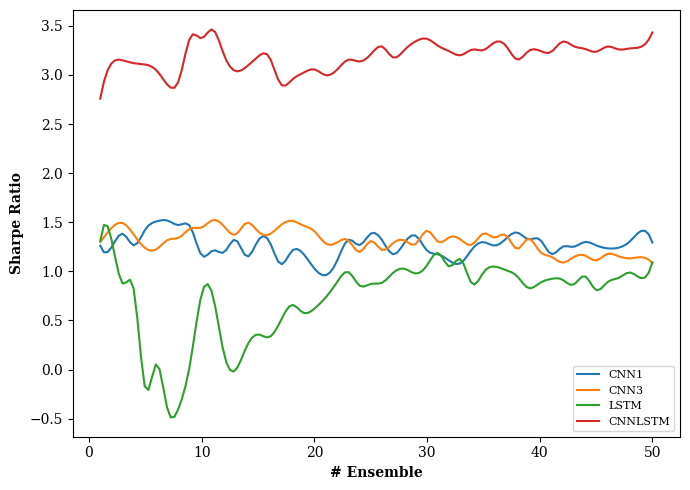

In [ ]:
# Compute and Plot Sharpe Ratio (50 ensembles)
sharpe_scores_cnn1 = []
sharpe_scores_cnn3 = []
sharpe_scores_lstm = []
sharpe_scores_cnnlstm = []

n_models = 50
for k in range(1, n_models+1):
    ensemble_pred_cnn1 = np.mean(all_preds_cnn1[:k], axis=0)
    ensemble_pred_cnn3 = np.mean(all_preds_cnn3[:k], axis=0)
    ensemble_pred_lstm = np.mean(all_preds_lstm[:k], axis=0)
    ensemble_pred_cnnlstm = np.mean(all_preds_cnnlstm[:k], axis=0)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn1, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN1_returns = model_returns(df_m)
    CNN1_returns = CNN1_returns.to_frame()
    CNN1_returns.rename(columns={'y_true': 'CNN1'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn3, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN3_returns = model_returns(df_m)
    CNN3_returns = CNN3_returns.to_frame()
    CNN3_returns.rename(columns={'y_true': 'CNN3'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_lstm, 'y_true': y_test_lstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_lstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_lstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    LSTM_returns = model_returns(df_m)
    LSTM_returns = LSTM_returns.to_frame()
    LSTM_returns.rename(columns={'y_true': 'LSTM'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnnlstm, 'y_true': y_test_cnnlstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnnlstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnnlstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNNLSTM_returns = model_returns(df_m)
    CNNLSTM_returns = CNNLSTM_returns.to_frame()
    CNNLSTM_returns.rename(columns={'y_true': 'CNNLSTM'}, inplace=True)

    sharpe_cnn1 = CNN1_returns.mean() / CNN1_returns.std() * np.sqrt(12)
    sharpe_cnn3 = CNN3_returns.mean() / CNN3_returns.std() * np.sqrt(12)
    sharpe_lstm = LSTM_returns.mean() / LSTM_returns.std() * np.sqrt(12)
    sharpe_cnnlstm = CNNLSTM_returns.mean() / CNNLSTM_returns.std() * np.sqrt(12)
    sharpe_scores_cnn1.append(sharpe_cnn1[0])
    sharpe_scores_cnn3.append(sharpe_cnn3[0])
    sharpe_scores_lstm.append(sharpe_lstm[0])
    sharpe_scores_cnnlstm.append(sharpe_cnnlstm[0])

# Plot Sharpe Ratio
def smooth_plot(x_num, y_raw, label=None, color=None):
    x_dense = np.linspace(min(x_num), max(x_num), 150)
    spline = make_interp_spline(x_num, y_raw, k=3)
    y_smooth = spline(x_dense)

    plt.plot(x_dense, y_smooth, label=label, color=color, linestyle='-', linewidth=1.5)

plt.figure(figsize=(7, 5))
plt.rcParams['font.family'] = 'serif'
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_cnn1, label='CNN1')
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_cnn3, label='CNN3')
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_lstm, label='LSTM')
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_cnnlstm, label='CNNLSTM')
# plt.title("Ensemble Averaging Impact on Sharpe Ratio")
plt.xlabel("# Ensemble", fontweight='bold')
plt.ylabel("Sharpe Ratio", fontweight='bold')
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
plt.grid(False)

plt.tight_layout()
plt.legend(fontsize=8)
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/Sharpe Across Ensemble_0716.png', dpi=200, bbox_inches='tight')
plt.show()

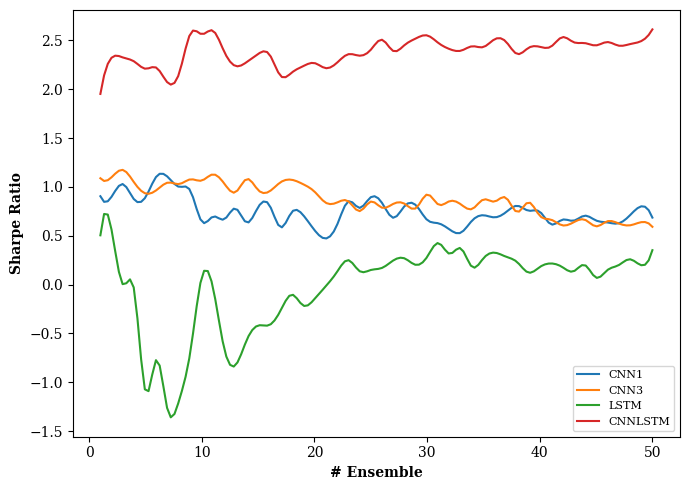

In [ ]:
# Sharpe ratio with Transaction Cost
sharpe_scores_cnn1 = []
sharpe_scores_cnn3 = []
sharpe_scores_lstm = []
sharpe_scores_cnnlstm = []

n_models = 50
for k in range(1, n_models+1):
    ensemble_pred_cnn1 = np.mean(all_preds_cnn1[:k], axis=0)
    ensemble_pred_cnn3 = np.mean(all_preds_cnn3[:k], axis=0)
    ensemble_pred_lstm = np.mean(all_preds_lstm[:k], axis=0)
    ensemble_pred_cnnlstm = np.mean(all_preds_cnnlstm[:k], axis=0)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn1, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN1_returns = model_returns_with_cost(df_m)
    CNN1_returns = CNN1_returns.to_frame()
    CNN1_returns.rename(columns={'y_true': 'CNN1'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnn3, 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN3_returns = model_returns_with_cost(df_m)
    CNN3_returns = CNN3_returns.to_frame()
    CNN3_returns.rename(columns={'y_true': 'CNN3'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_lstm, 'y_true': y_test_lstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_lstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_lstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    LSTM_returns = model_returns_with_cost(df_m)
    LSTM_returns = LSTM_returns.to_frame()
    LSTM_returns.rename(columns={'y_true': 'LSTM'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': ensemble_pred_cnnlstm, 'y_true': y_test_cnnlstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnnlstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnnlstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNNLSTM_returns = model_returns_with_cost(df_m)
    CNNLSTM_returns = CNNLSTM_returns.to_frame()
    CNNLSTM_returns.rename(columns={'y_true': 'CNNLSTM'}, inplace=True)

    sharpe_cnn1 = CNN1_returns.mean() / CNN1_returns.std() * np.sqrt(12)
    sharpe_cnn3 = CNN3_returns.mean() / CNN3_returns.std() * np.sqrt(12)
    sharpe_lstm = LSTM_returns.mean() / LSTM_returns.std() * np.sqrt(12)
    sharpe_cnnlstm = CNNLSTM_returns.mean() / CNNLSTM_returns.std() * np.sqrt(12)
    sharpe_scores_cnn1.append(sharpe_cnn1[0])
    sharpe_scores_cnn3.append(sharpe_cnn3[0])
    sharpe_scores_lstm.append(sharpe_lstm[0])
    sharpe_scores_cnnlstm.append(sharpe_cnnlstm[0])

# Plot Sharpe Ratio
def smooth_plot(x_num, y_raw, label=None, color=None):
    x_dense = np.linspace(min(x_num), max(x_num), 150)
    spline = make_interp_spline(x_num, y_raw, k=3)
    y_smooth = spline(x_dense)

    plt.plot(x_dense, y_smooth, label=label, color=color, linestyle='-', linewidth=1.5)

plt.figure(figsize=(7, 5))
plt.rcParams['font.family'] = 'serif'
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_cnn1, label='CNN1')
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_cnn3, label='CNN3')
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_lstm, label='LSTM')
smooth_plot(list(range(1, n_models + 1)), sharpe_scores_cnnlstm, label='CNNLSTM')
# plt.title("Ensemble Averaging Impact on Sharpe Ratio")
plt.xlabel("# Ensemble", fontweight='bold')
plt.ylabel("Sharpe Ratio", fontweight='bold')
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
plt.grid(False)

plt.tight_layout()
plt.legend(fontsize=8)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/Sharpe Across Ensemble_with_cost0.001.png', dpi=200, bbox_inches='tight')
plt.show()

/tmp/ipython-input-1514368176.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 10) # replace 'darkslategray'


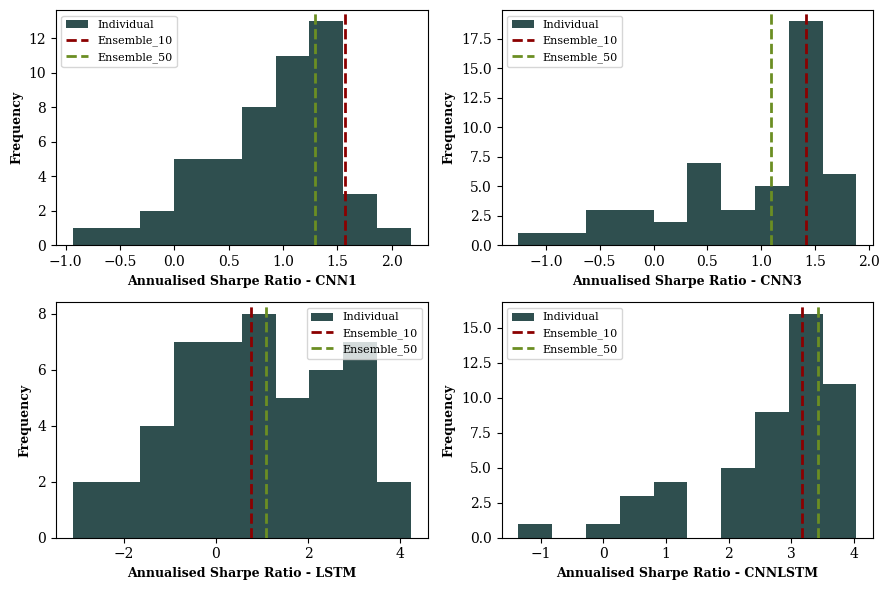

In [ ]:
# Ensemble Distribution without Transaction Cost
sharpe_scores_cnn1 = []
sharpe_scores_cnn3 = []
sharpe_scores_lstm = []
sharpe_scores_cnnlstm = []

n_models = 50
for k in range(n_models):
    df_m = pd.DataFrame({'y_pred': all_preds_cnn1[k], 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN1_returns = model_returns(df_m)
    CNN1_returns = CNN1_returns.to_frame()
    CNN1_returns.rename(columns={'y_true': 'CNN1_50'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': all_preds_cnn3[k], 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN3_returns = model_returns(df_m)
    CNN3_returns = CNN3_returns.to_frame()
    CNN3_returns.rename(columns={'y_true': 'CNN3_50'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': all_preds_lstm[k], 'y_true': y_test_lstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_lstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_lstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    LSTM_returns = model_returns(df_m)
    LSTM_returns = LSTM_returns.to_frame()
    LSTM_returns.rename(columns={'y_true': 'CNNLSTM_50'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': all_preds_cnnlstm[k], 'y_true': y_test_cnnlstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnnlstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnnlstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNNLSTM_returns = model_returns(df_m)
    CNNLSTM_returns = CNNLSTM_returns.to_frame()
    CNNLSTM_returns.rename(columns={'y_true': 'CNNLSTM_50'}, inplace=True)

    sharpe_cnn1 = CNN1_returns.mean() / CNN1_returns.std() * np.sqrt(12)
    sharpe_cnn3 = CNN3_returns.mean() / CNN3_returns.std() * np.sqrt(12)
    sharpe_lstm = LSTM_returns.mean() / LSTM_returns.std() * np.sqrt(12)
    sharpe_cnnlstm = CNNLSTM_returns.mean() / CNNLSTM_returns.std() * np.sqrt(12)
    sharpe_scores_cnn1.append(sharpe_cnn1[0])
    sharpe_scores_cnn3.append(sharpe_cnn3[0])
    sharpe_scores_lstm.append(sharpe_lstm[0])
    sharpe_scores_cnnlstm.append(sharpe_cnnlstm[0])

ensemble10_sharpe_ratios_no_fees = [1.57, 1.41, 0.77, 3.17]
ensemble50_sharpe_ratios_no_fees = [1.29,	1.09,	1.09,	3.43]

plt.figure(figsize=(9, 6))
plt.rcParams['font.family'] = 'serif'
cmap = cm.get_cmap('Blues', 10) # replace 'darkslategray'

plt.subplot(2,2,1)
plt.hist(sharpe_scores_cnn1, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_no_fees[0], color='darkred', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_no_fees[0], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - CNN1',fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hist_cnn1_no_fees.png', dpi=200, bbox_inches='tight')

plt.subplot(2,2,2)
plt.hist(sharpe_scores_cnn3, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_no_fees[1], color='darkred', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_no_fees[1], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - CNN3', fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hist_cnn3_no_fees.png', dpi=200, bbox_inches='tight')

plt.subplot(2,2,3)
plt.hist(sharpe_scores_lstm, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_no_fees[2], color='darkred', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_no_fees[2], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - LSTM',fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hist_lstm_no_fees.png', dpi=200, bbox_inches='tight')

plt.subplot(2,2,4)
plt.hist(sharpe_scores_cnnlstm, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_no_fees[3], color='darkred', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_no_fees[3], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - CNNLSTM',fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hists_no_fees.png', dpi=200, bbox_inches='tight')

plt.show()

In [ ]:
ensemble10_sharpe_ratios_no_fees = [1.57, 1.41, 0.77, 3.17]
ensemble50_sharpe_ratios_no_fees = [1.29,	1.09,	1.09,	3.43]
individual_mean_cnn1 = np.mean(sharpe_scores_cnn1)
individual_mean_cnn3 = np.mean(sharpe_scores_cnn3)
individual_mean_lstm = np.mean(sharpe_scores_lstm)
individual_mean_cnnlstm = np.mean(sharpe_scores_cnnlstm)
print(f"Individual Mean Sharpe Ratio - CNN1: {individual_mean_cnn1:.6f}")
print(f"Individual Mean Sharpe Ratio - CNN3: {individual_mean_cnn3:.6f}")
print(f"Individual Mean Sharpe Ratio - LSTM: {individual_mean_lstm:.6f}")
print(f"Individual Mean Sharpe Ratio - CNNLSTM: {individual_mean_cnnlstm:.6f}")

Individual Mean Sharpe Ratio - CNN1: 0.882206
Individual Mean Sharpe Ratio - CNN3: 0.895726
Individual Mean Sharpe Ratio - LSTM: 0.852086
Individual Mean Sharpe Ratio - CNNLSTM: 2.638895


/tmp/ipython-input-2859625167.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02083333 0.02083333 0.02083333 ... 0.02040816 0.02040816 0.02040816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[long_mask, 'w_t'] = 1 / df[long_mask].groupby('month')['PERMNO'].transform('count')
/tmp/ipython-input-2859625167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_port  = portfolio.groupby('month').apply(lambda x: (x['w_t'] * x['r_i']).sum())
/tmp/ipython-input-2859625167.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an

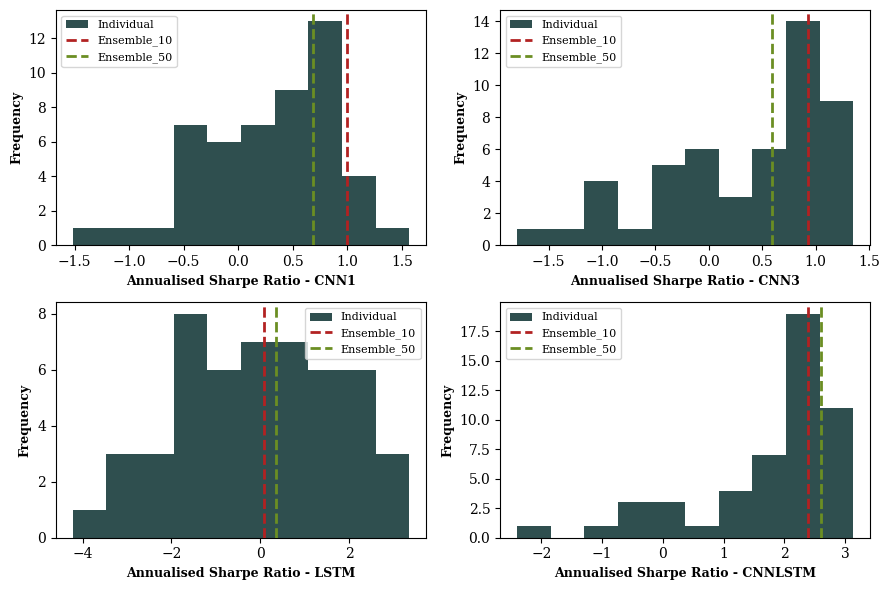

In [ ]:
# Ensemble Distribution with Transaction Cost
sharpe_scores_cnn1 = []
sharpe_scores_cnn3 = []
sharpe_scores_lstm = []
sharpe_scores_cnnlstm = []

n_models = 50
for k in range(n_models):
    df_m = pd.DataFrame({'y_pred': all_preds_cnn1[k], 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN1_returns = model_returns_with_cost(df_m)
    CNN1_returns = CNN1_returns.to_frame()
    CNN1_returns.rename(columns={'y_true': 'CNN1_50'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': all_preds_cnn3[k], 'y_true': y_test_cnn})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnn):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnn):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNN3_returns = model_returns_with_cost(df_m)
    CNN3_returns = CNN3_returns.to_frame()
    CNN3_returns.rename(columns={'y_true': 'CNN3_50'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': all_preds_lstm[k], 'y_true': y_test_lstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_lstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_lstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    LSTM_returns = model_returns_with_cost(df_m)
    LSTM_returns = LSTM_returns.to_frame()
    LSTM_returns.rename(columns={'y_true': 'CNNLSTM_50'}, inplace=True)

    df_m = pd.DataFrame({'y_pred': all_preds_cnnlstm[k], 'y_true': y_test_cnnlstm})
    df_m['PERMNO'] = df_all.iloc[-len(y_test_cnnlstm):,:]['PERMNO'].reset_index(drop=True)
    df_m['month'] = df_all.iloc[-len(y_test_cnnlstm):,:]['month'].reset_index(drop=True)
    df_m = df_m[['PERMNO','month','y_pred','y_true']]
    CNNLSTM_returns = model_returns_with_cost(df_m)
    CNNLSTM_returns = CNNLSTM_returns.to_frame()
    CNNLSTM_returns.rename(columns={'y_true': 'CNNLSTM_50'}, inplace=True)

    sharpe_cnn1 = CNN1_returns.mean() / CNN1_returns.std() * np.sqrt(12)
    sharpe_cnn3 = CNN3_returns.mean() / CNN3_returns.std() * np.sqrt(12)
    sharpe_lstm = LSTM_returns.mean() / LSTM_returns.std() * np.sqrt(12)
    sharpe_cnnlstm = CNNLSTM_returns.mean() / CNNLSTM_returns.std() * np.sqrt(12)
    sharpe_scores_cnn1.append(sharpe_cnn1[0])
    sharpe_scores_cnn3.append(sharpe_cnn3[0])
    sharpe_scores_lstm.append(sharpe_lstm[0])
    sharpe_scores_cnnlstm.append(sharpe_cnnlstm[0])

ensemble10_sharpe_ratios_10bp_fees = [1.00,	0.93,	0.08,	2.39]
ensemble50_sharpe_ratios_10bp_fees = [0.69,	0.59,	0.35,	2.61]

plt.figure(figsize=(9, 6))
plt.rcParams['font.family'] = 'serif'
cmap = cm.get_cmap('Blues', 10) # replace 'darkslategray'

plt.subplot(2,2,1)
plt.hist(sharpe_scores_cnn1, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_10bp_fees[0], color='firebrick', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_10bp_fees[0], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - CNN1',fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hist_cnn1_10bp_fees.png', dpi=200, bbox_inches='tight')

plt.subplot(2,2,2)
plt.hist(sharpe_scores_cnn3, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_10bp_fees[1], color='firebrick', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_10bp_fees[1], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - CNN3', fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hist_cnn3_10bp_fees.png', dpi=200, bbox_inches='tight')

plt.subplot(2,2,3)
plt.hist(sharpe_scores_lstm, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_10bp_fees[2], color='firebrick', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_10bp_fees[2], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - LSTM',fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hist_lstm_10bp_fees.png', dpi=200, bbox_inches='tight')

plt.subplot(2,2,4)
plt.hist(sharpe_scores_cnnlstm, color='darkslategray', label='Individual', zorder=2)
plt.axvline(x=ensemble10_sharpe_ratios_10bp_fees[3], color='firebrick', linestyle='--', linewidth=2, label='Ensemble_10', zorder=3)
plt.axvline(x=ensemble50_sharpe_ratios_10bp_fees[3], color='olivedrab', linestyle='--', linewidth=2, label='Ensemble_50', zorder=3)
plt.xlabel('Annualised Sharpe Ratio - CNNLSTM',fontweight='bold',fontsize=9)
plt.ylabel('Frequency',fontweight='bold',fontsize=9)
plt.legend(fontsize=8)
plt.grid(False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/sharpe_hists_10bp_fees.png', dpi=200, bbox_inches='tight')

plt.show()

In [ ]:
ensemble10_sharpe_ratios_10bp_fees = [1.00,	0.93,	0.08,	2.39]
ensemble50_sharpe_ratios_10bp_fees = [0.69,	0.59,	0.35,	2.61]
individual_mean_cnn1 = np.mean(sharpe_scores_cnn1)
individual_mean_cnn3 = np.mean(sharpe_scores_cnn3)
individual_mean_lstm = np.mean(sharpe_scores_lstm)
individual_mean_cnnlstm = np.mean(sharpe_scores_cnnlstm)
print(f"Individual Mean Sharpe Ratio - CNN1: {individual_mean_cnn1:.6f}")
print(f"Individual Mean Sharpe Ratio - CNN3: {individual_mean_cnn3:.6f}")
print(f"Individual Mean Sharpe Ratio - LSTM: {individual_mean_lstm:.6f}")
print(f"Individual Mean Sharpe Ratio - CNNLSTM: {individual_mean_cnnlstm:.6f}")

Individual Mean Sharpe Ratio - CNN1: 0.292192
Individual Mean Sharpe Ratio - CNN3: 0.361055
Individual Mean Sharpe Ratio - LSTM: -0.014107
Individual Mean Sharpe Ratio - CNNLSTM: 1.797861


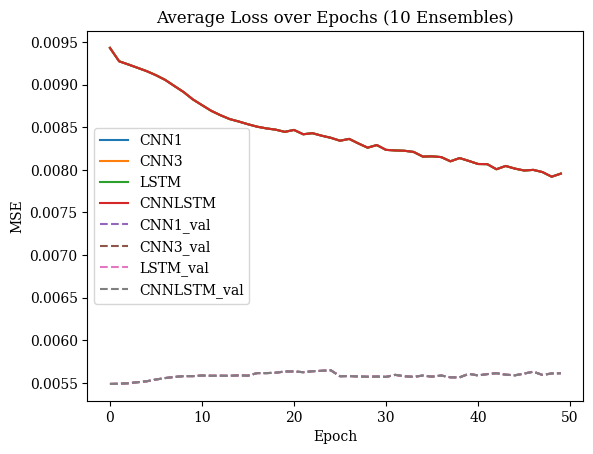

In [ ]:
# Validation Loss
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cnn1_50ens_losses.pkl', 'rb') as f:
    loss_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cnn3_50ens_losses.pkl', 'rb') as f:
    loss_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/lstm_50ens_losses.pkl', 'rb') as f:
    loss_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Dissertation Project/20yrs/cnnlstm_50ens_losses.pkl', 'rb') as f:
    loss_data = pickle.load(f)

train_losses_cnn1 = loss_data['train']
train_losses_cnn3 = loss_data['train']
train_losses_lstm = loss_data['train']
train_losses_cnnlstm = loss_data['train']

val_losses_cnn1 = loss_data['val']
val_losses_cnn3 = loss_data['val']
val_losses_lstm = loss_data['val']
val_losses_cnnlstm = loss_data['val']

min_val_losses_cnn1 = loss_data['min_val']
min_val_losses_cnn3 = loss_data['min_val']
min_val_losses_lstm = loss_data['min_val']
min_val_losses_cnnlstm = loss_data['min_val']

# Find the maximum number of epochs across all models
max_epochs = max(len(losses) for losses in train_losses_cnn1)
max_epochs = max(len(losses) for losses in train_losses_cnn3)
max_epochs = max(len(losses) for losses in train_losses_lstm)
max_epochs = max(len(losses) for losses in train_losses_cnnlstm)

# Pad the shorter loss lists with NaN
padded_train_losses_cnn1 = [loss + [np.nan] * (max_epochs - len(loss)) for loss in train_losses_cnn1]
padded_train_losses_cnn3 = [loss + [np.nan] * (max_epochs - len(loss)) for loss in train_losses_cnn3]
padded_train_losses_lstm = [loss + [np.nan] * (max_epochs - len(loss)) for loss in train_losses_lstm]
padded_train_losses_cnnlstm = [loss + [np.nan] * (max_epochs - len(loss)) for loss in train_losses_cnnlstm]

padded_val_losses_cnn1 = [loss + [np.nan] * (max_epochs - len(loss)) for loss in val_losses_cnn1]
padded_val_losses_cnn3 = [loss + [np.nan] * (max_epochs - len(loss)) for loss in val_losses_cnn3]
padded_val_losses_lstm = [loss + [np.nan] * (max_epochs - len(loss)) for loss in val_losses_lstm]
padded_val_losses_cnnlstm = [loss + [np.nan] * (max_epochs - len(loss)) for loss in val_losses_cnnlstm]

# plt.figure(figsize=(7, 5))
plt.rcParams['font.family'] = 'serif'
# Average across all 50 models (axis=0), ignoring NaN values
avg_train_loss_cnn1 = np.nanmean(np.array(padded_train_losses_cnn1), axis=0)
avg_train_loss_cnn3 = np.nanmean(np.array(padded_train_losses_cnn3), axis=0)
avg_train_loss_lstm = np.nanmean(np.array(padded_train_losses_lstm), axis=0)
avg_train_loss_cnnlstm = np.nanmean(np.array(padded_train_losses_cnnlstm), axis=0)

avg_val_loss_cnn1 = np.nanmean(np.array(padded_val_losses_cnn1), axis=0)
avg_val_loss_cnn3 = np.nanmean(np.array(padded_val_losses_cnn3), axis=0)
avg_val_loss_lstm = np.nanmean(np.array(padded_val_losses_lstm), axis=0)
avg_val_loss_cnnlstm = np.nanmean(np.array(padded_val_losses_cnnlstm), axis=0)

plt.plot(list(range(1, Epoch + 1)), avg_train_loss_cnn1, label='CNN1', linestyle='-', linewidth=1.5)
plt.plot(list(range(1, n_models + 1)), avg_train_loss_cnn3, label='CNN3', linestyle='-', linewidth=1.5)
plt.plot(list(range(1, n_models + 1)), avg_train_loss_lstm, label='LSTM', linestyle='-', linewidth=1.5)
plt.plot(avg_train_loss_cnnlstm, label='CNNLSTM', linestyle='-', linewidth=1.5)
plt.plot(avg_val_loss_cnn1, label='CNN1_val', linestyle='--', linewidth=1.5)
plt.plot(avg_val_loss_cnn3, label='CNN3_val', linestyle='--', linewidth=1.5)
plt.plot(avg_val_loss_lstm, label='LSTM_val', linestyle='--', linewidth=1.5)
plt.plot(avg_val_loss_cnnlstm, label='CNNLSTM_val', linestyle='--', linewidth=1.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Average Loss over Epochs (10 Ensembles)')
plt.legend()
plt.grid(False)
plt.show()